# Evaluate mock community classification accuracy
The purpose of this notebook is to evaluate taxonomic classification accuracy of mock communities using different classification methods.

Prepare the environment
-----------------------

First we'll import various functions that we'll need for generating the report. 

In [1]:
%matplotlib inline
from os.path import join, exists, expandvars
import pandas as pd
from IPython.display import display, Markdown
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           boxplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           beta_diversity_pcoa,
                                           average_distance_boxplots,
                                           rank_optimized_method_performance_by_dataset)
from tax_credit.eval_framework import (evaluate_results,
                                       method_by_dataset_a1,
                                       parameter_comparisons,
                                       merge_expected_and_observed_tables)

Configure local environment-specific values
-------------------------------------------

**This is the only cell that you will need to edit to generate basic reports locally.** After editing this cell, you can run all cells in this notebook to generate your analysis report. This will take a few minutes to run, as results are computed at multiple taxonomic levels.

Values in this cell will not need to be changed, with the exception of ``project_dir``, to generate the default results contained within tax-credit. To analyze results separately from the tax-credit precomputed results, other variables in this cell will need to be set.

In [2]:
## project_dir should be the directory where you've downloaded (or cloned) the 
## short-read-tax-assignment repository. 
project_dir = expandvars("/Users/benkaehler/Projects/short-read-tax-assignment-bk/")

## expected_results_dir contains expected composition data in the structure
## expected_results_dir/<dataset name>/<reference name>/expected/
expected_results_dir = join(project_dir, "data/precomputed-results/", "mock-community")

## mock_results_fp designates the files to which summary results are written.
## If this file exists, it can be read in to generate results plots, instead
## of computing new scores.
mock_results_fp = join(expected_results_dir, 'mock_results.tsv')

## results_dirs should contain the directory or directories where
## results can be found. By default, this is the same location as expected 
## results included with the project. If other results should be included, 
## absolute paths to those directories should be added to this list.
results_dirs = [expected_results_dir]

## directory containing mock community data, e.g., feature table without taxonomy
mock_dir = join(project_dir, "data", "mock-community")

## Minimum number of times an OTU must be observed for it to be included in analyses. Edit this
## to analyze the effect of the minimum count on taxonomic results.
min_count = 1

## Define the range of taxonomic levels over which to compute accuracy scores.
## The default given below will compute order (level 2) through species (level 6)
taxonomy_level_range = range(2,7)

Find mock community pre-computed tables, expected tables, and "query" tables
----------------------------------------------------------------------------

Next we'll use the paths defined above to find all of the tables that will be compared. These include the *pre-computed result* tables (i.e., the ones that the new methods will be compared to), the *expected result* tables (i.e., the tables containing the known composition of the mock microbial communities), and the *query result* tables (i.e., the tables generated with the new method(s) that we want to compare to the *pre-computed result* tables).

**Note**: if you have added additional methods and are attempting to recompute results, set force=True.

This cell will take a few minutes to run, so hold onto your hat.

In [3]:
mock_results = evaluate_results(results_dirs, 
                                expected_results_dir, 
                                mock_results_fp, 
                                mock_dir,
                                taxonomy_level_range=range(2,7), 
                                min_count=min_count,
                                taxa_to_keep=None, 
                                md_key='taxonomy', 
                                subsample=False,
                                per_seq_precision=True,
                                exclude=['other'],
                                force=True)

/Users/benkaehler/miniconda3/envs/qiime2-dev/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/benkaehler/miniconda3/envs/qiime2-dev/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Restrict analyses to a set of datasets or references: e.g., exclude taxonomy assignments made for purpose of reference database comparisons.

In [4]:
mock_results = mock_results[mock_results['Reference'].isin(['gg_13_8_otus', 'unite_20.11.2016_clean_fullITS'])]
mock_results = mock_results[mock_results['Dataset'].isin(['mock-1', 'mock-2', 'mock-3', 'mock-4',
                                                          'mock-5', 'mock-7', 'mock-8', 'mock-9',
                                                          'mock-10', 'mock-12', 'mock-16', 'mock-18',
                                                          'mock-19', 'mock-20', 'mock-21', 'mock-22',
                                                          'mock-23', 'mock-24', 'mock-25', 'mock-26'])]

Compute and summarize precision, recall, and F-measure for mock communities
----------------------------------------------------------------------------------------

In this evaluation, we compute and summarize precision, recall, and F-measure of each result (pre-computed and query) based on the known composition of the mock communities. We then summarize the results in two ways: first with boxplots, and second with a table of the top methods based on their F-measures. 

As a first step, we will evaluate **average** method performance at each taxonomic level for each method within each reference dataset type.

**Note that, as parameter configurations can cause results to vary widely, average results are not a good representation of the "best" results. See [here](#Optimized-method-performance) for results using optimized parameters for each method.**

In [5]:
color_pallette={
    'expected': 'red', 'rdp': 'seagreen', 'sortmerna': 'gray',
    'uclust': 'blue', 'blast': 'black', 'blast+': 'purple', 'q2-nb': 'pink',
    'vsearch': 'brown'
}

y_vars = ["Precision", "Recall", "F-measure", "Taxon Accuracy Rate", "Taxon Detection Rate"]

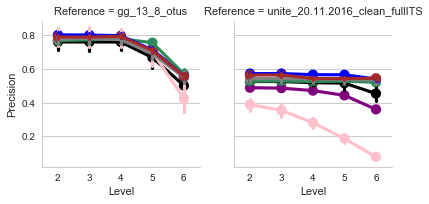

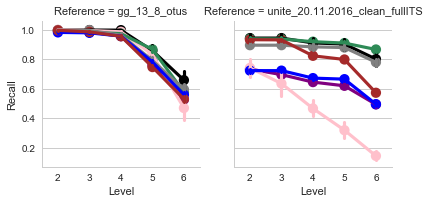

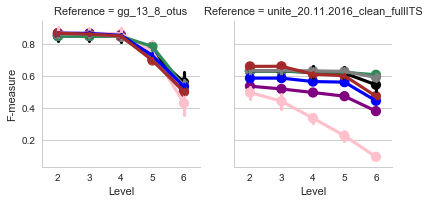

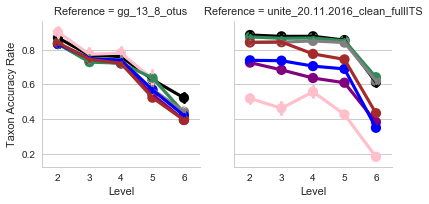

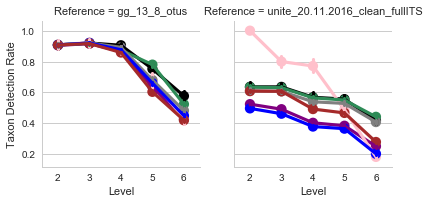

In [6]:
pointplot_from_data_frame(mock_results, "Level", y_vars, 
                          group_by="Reference", color_by="Method",
                          color_pallette=color_pallette)

### Kruskal-Wallis between-method accuracy comparisons
Kruskal-Wallis FDR-corrected p-values comparing classification methods at each level of taxonomic assignment

In [7]:
result = per_level_kruskal_wallis(mock_results, y_vars, group_by='Method', 
                                  dataset_col='Reference', level_name='Level',
                                  levelrange=range(2,7), alpha=0.05, 
                                  pval_correction='fdr_bh')
result

Reference              Variable              2  \
0                    gg_13_8_otus             Precision   1.077059e-02   
1                    gg_13_8_otus                Recall   6.293206e-28   
2                    gg_13_8_otus             F-measure   2.320716e-01   
3                    gg_13_8_otus   Taxon Accuracy Rate   6.959912e-06   
4                    gg_13_8_otus  Taxon Detection Rate   9.584542e-01   
5  unite_20.11.2016_clean_fullITS             Precision   4.601516e-28   
6  unite_20.11.2016_clean_fullITS                Recall   0.000000e+00   
7  unite_20.11.2016_clean_fullITS             F-measure   2.173682e-55   
8  unite_20.11.2016_clean_fullITS   Taxon Accuracy Rate  4.384513e-265   
9  unite_20.11.2016_clean_fullITS  Taxon Detection Rate  2.337681e-127   

               3              4              5              6  
0   9.455196e-02   2.558814e-01   1.905525e-03   1.022860e-02  
1   9.844389e-15   7.991753e-23   1.486565e-17   4.265048e-05  
2   5.350801e-01   9.777715e-01   1.336838e-06   1.905525e-03  
3   8.134356e-02   5.010372e-03   2.476416e-23   7.578604e-16  
4   8.763574e-01   5.649290e-07   5.948615e-47   4.774055e-32  
5   1.930879e-29   1.067839e-30   7.536402e-53  1.084495e-132  
6   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00  
7   2.073542e-69   5.405091e-54   2.663020e-66  7.336023e-112  
8  2.122026e-308  4.685986e-305  9.104506e-280   0.000000e+00  
9  2.204186e-218  4.205315e-228  2.371274e-235   0.000000e+00

### Heatmaps of per-level accuracy
Heatmaps show the performance of individual method/parameter combinations at each taxonomic level, in each reference database (i.e., for bacterial and fungal mock communities individually).

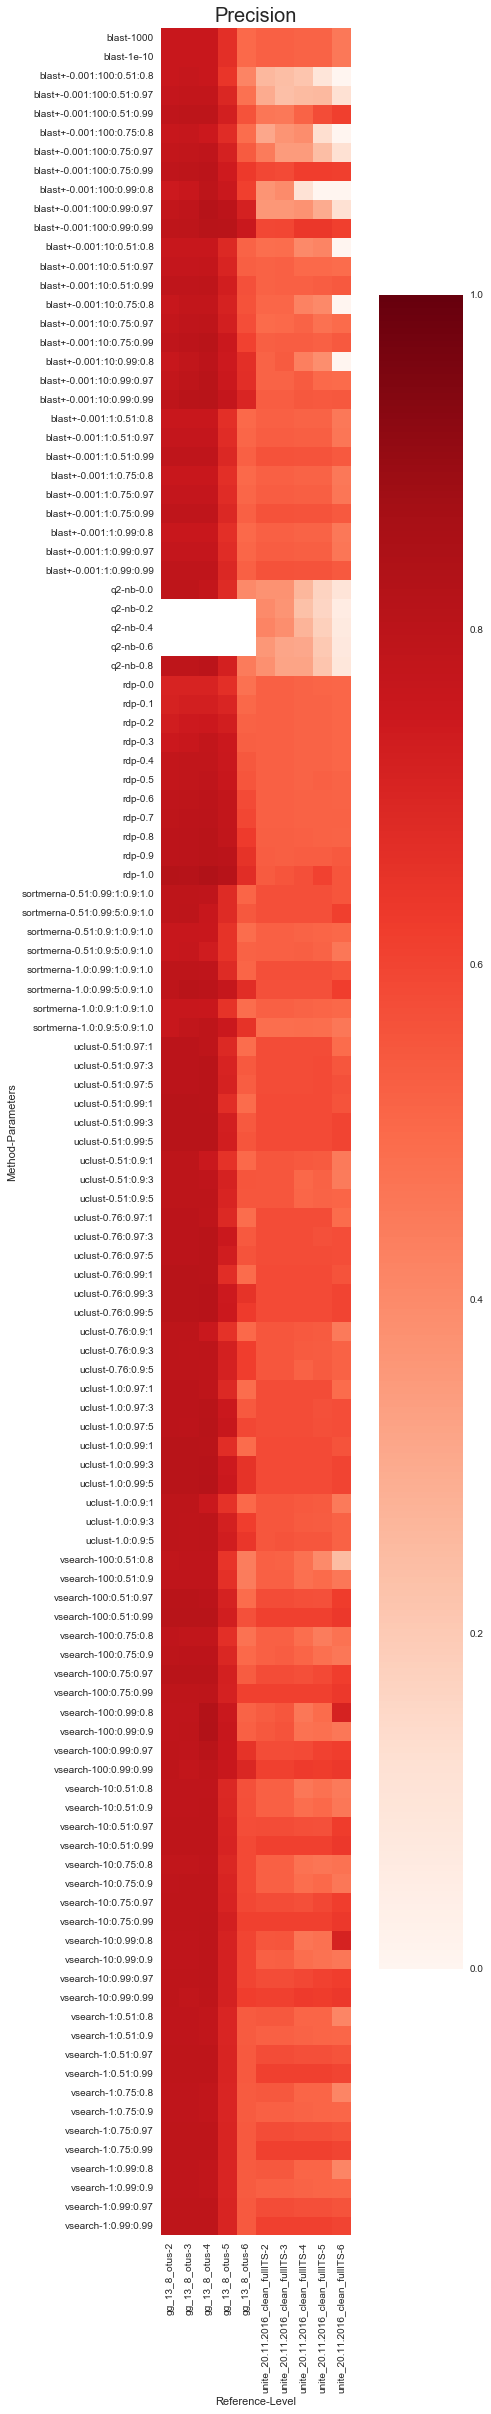

In [8]:
heatmap_from_data_frame(mock_results, metric="Precision", rows=["Method", "Parameters"], cols=["Reference", "Level"])

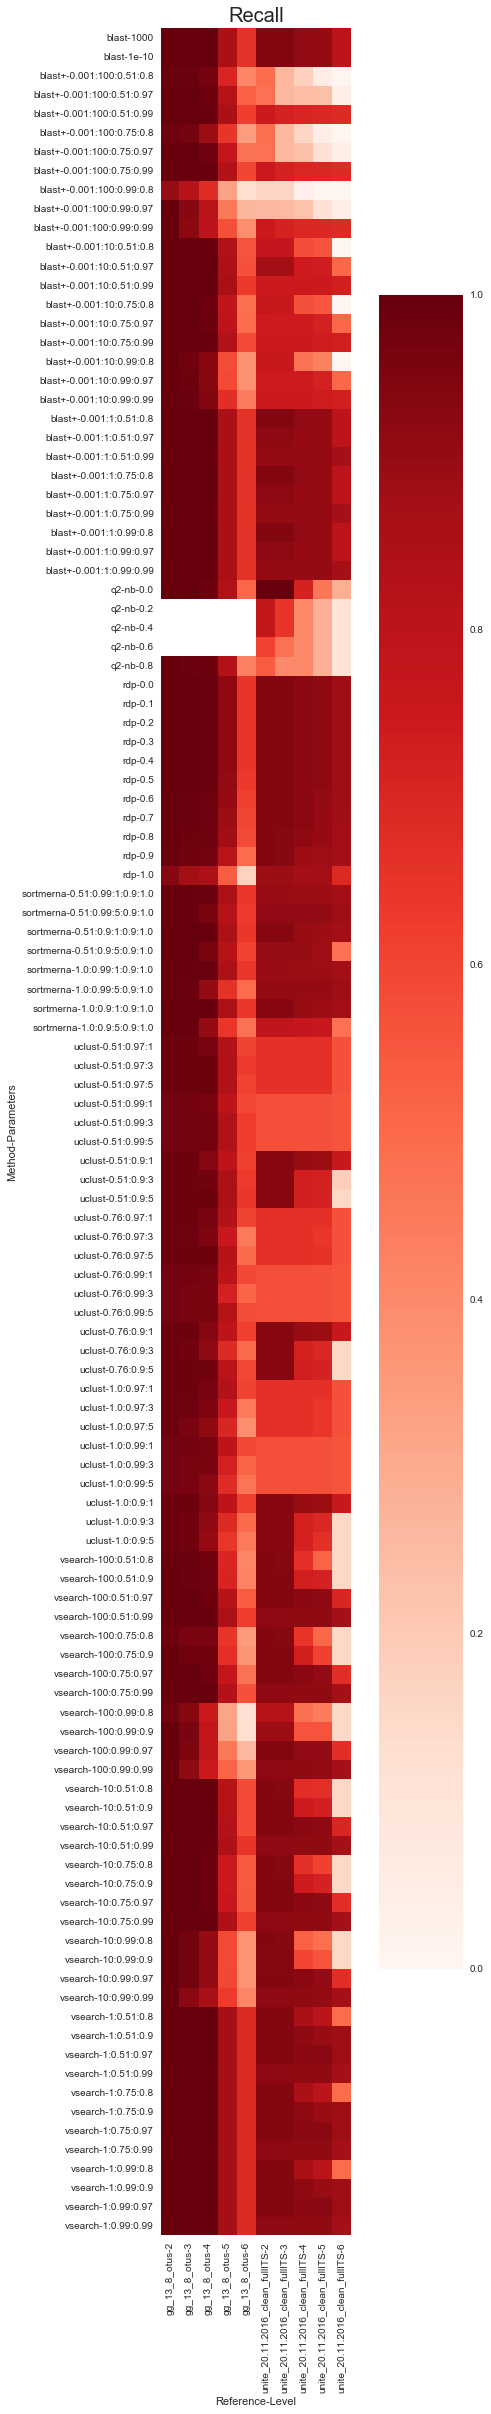

In [9]:
heatmap_from_data_frame(mock_results, metric="Recall", rows=["Method", "Parameters"], cols=["Reference", "Level"])

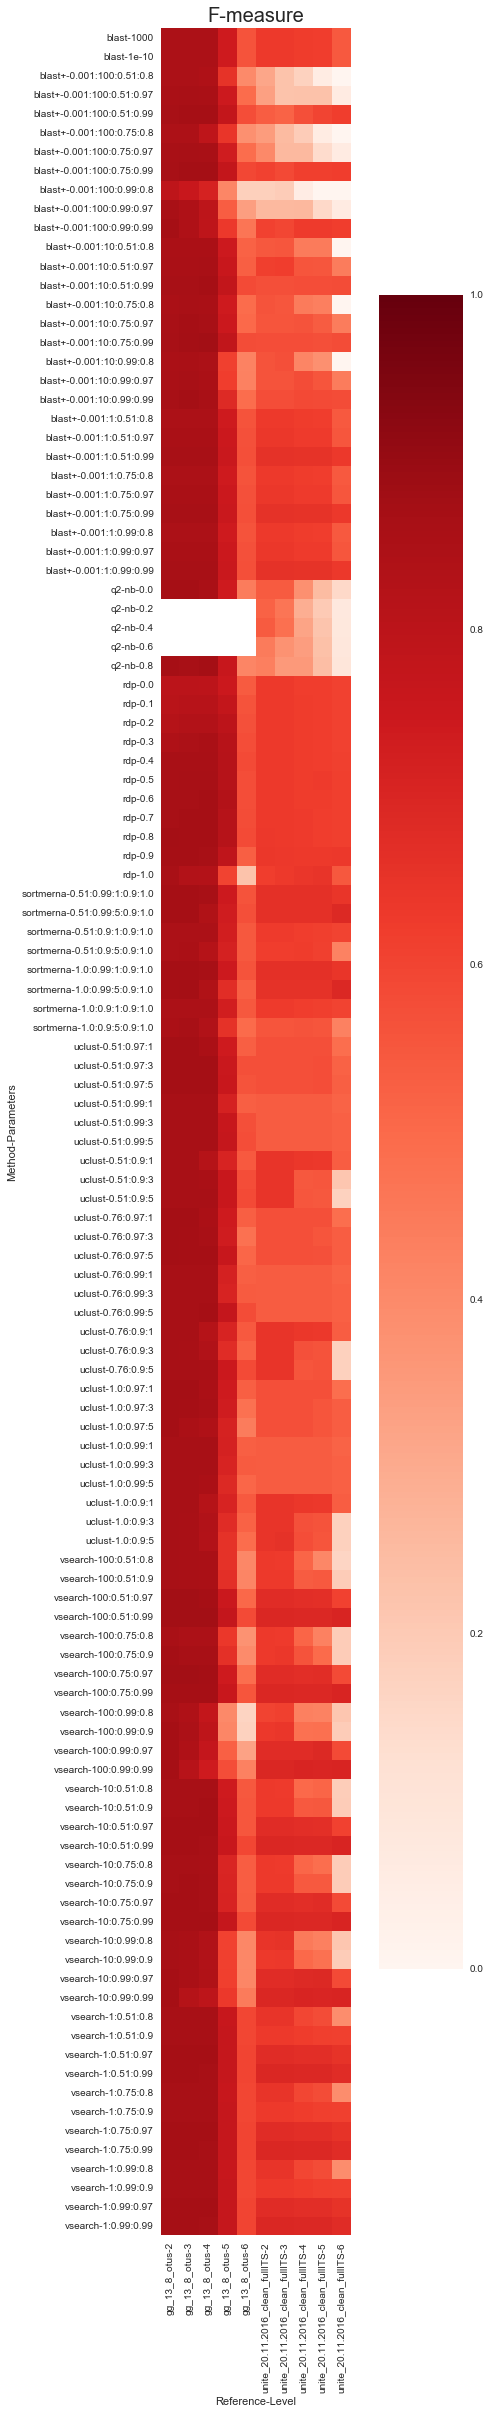

In [10]:
heatmap_from_data_frame(mock_results, metric="F-measure", rows=["Method", "Parameters"], cols=["Reference", "Level"])

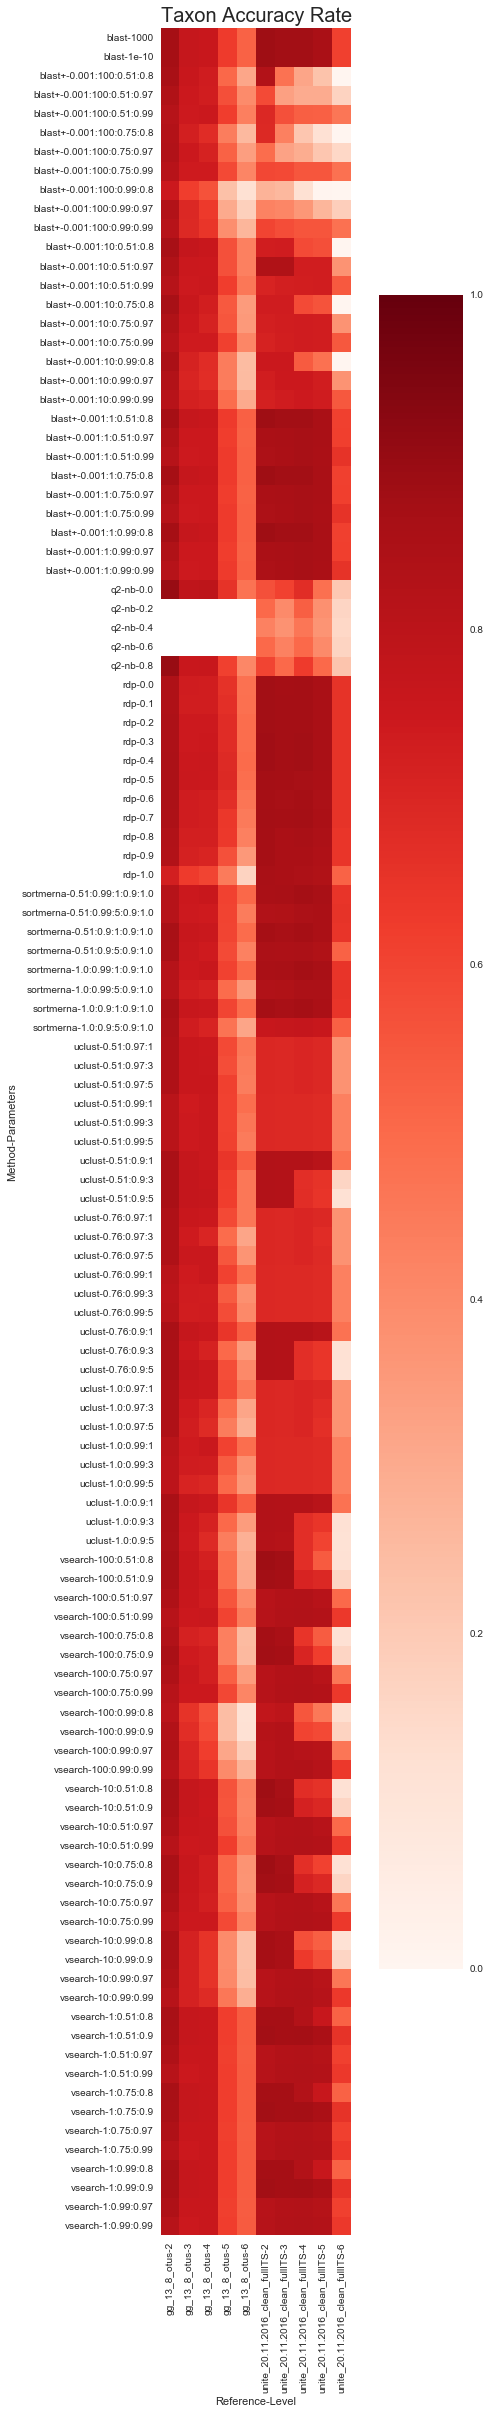

In [11]:
heatmap_from_data_frame(mock_results, metric="Taxon Accuracy Rate", rows=["Method", "Parameters"], cols=["Reference", "Level"])

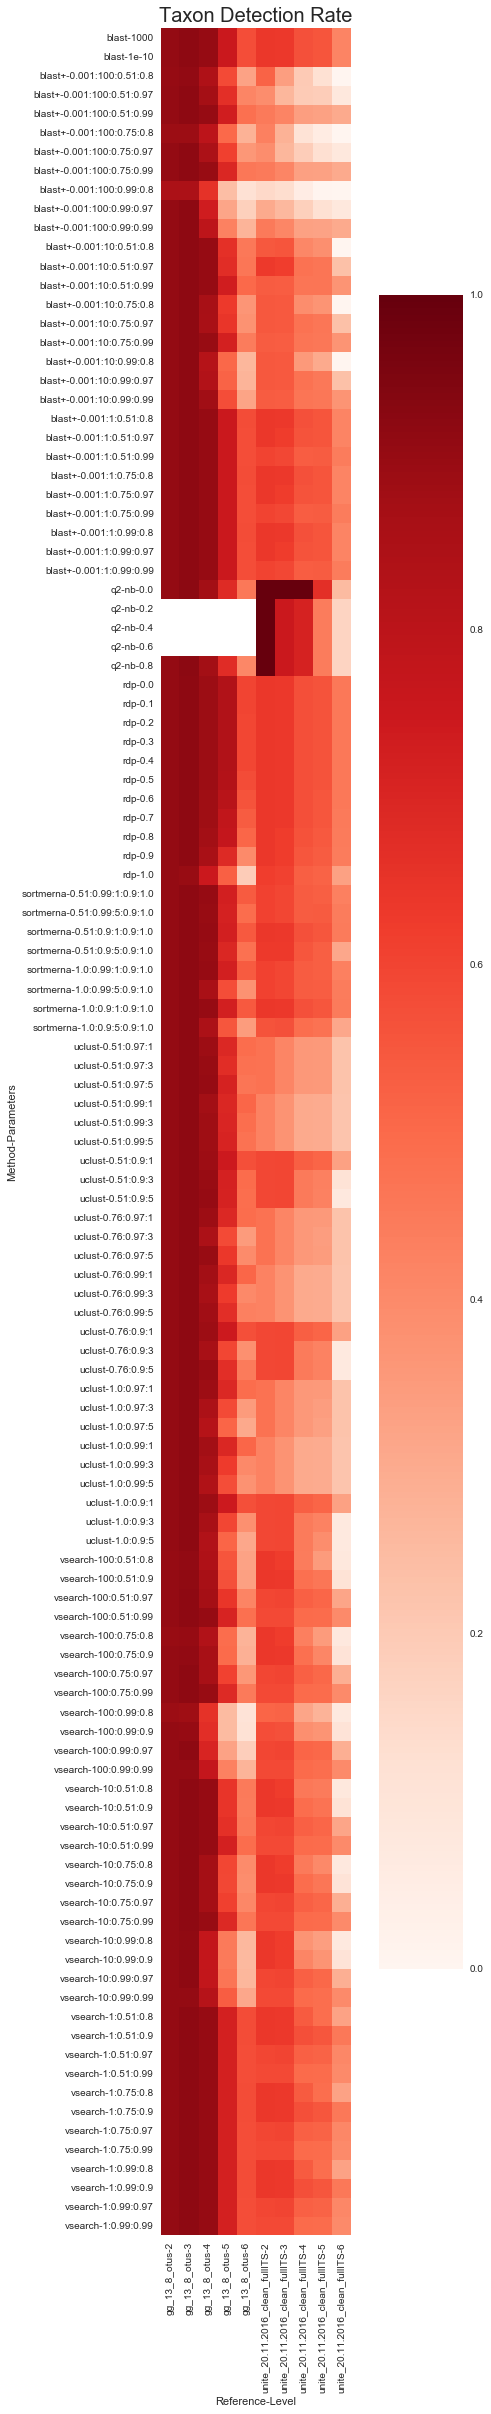

In [12]:
heatmap_from_data_frame(mock_results, metric="Taxon Detection Rate", rows=["Method", "Parameters"], cols=["Reference", "Level"])

Now we will focus on results at species level (for genus level, change to level 5)

In [13]:
mock_results_6 = mock_results[mock_results['Level'] == 6]

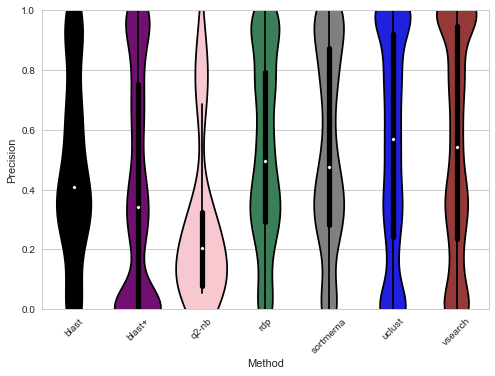

In [14]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Precision", color_pallette=color_pallette)

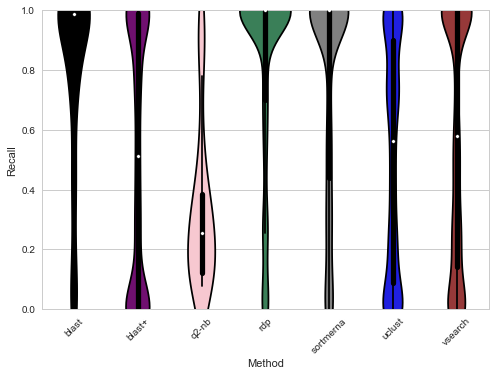

In [15]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Recall", color_pallette=color_pallette)

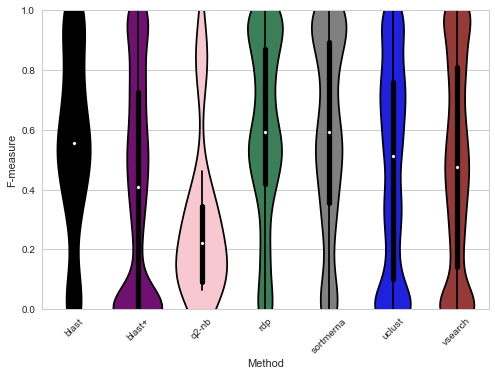

In [16]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="F-measure", color_pallette=color_pallette)

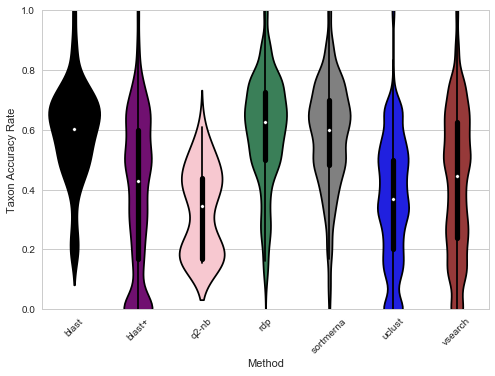

In [17]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Taxon Accuracy Rate", color_pallette=color_pallette)

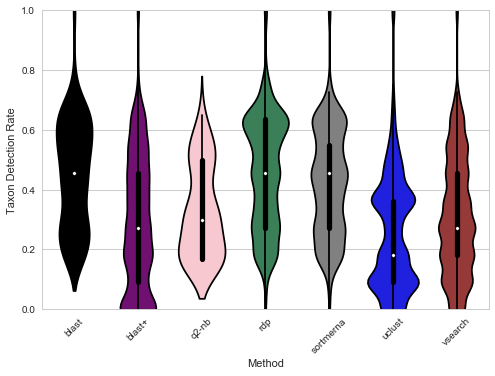

In [18]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Taxon Detection Rate", color_pallette=color_pallette)

In the following heatmaps, we assess accuracy rates in each dataset X method configuration combination. This allows us to assess how evenly configurations affect performance, whether specific mock communities outperform of underperform relative to others, and generally assess how increasing/decreasing specific parameters affects accuracy.

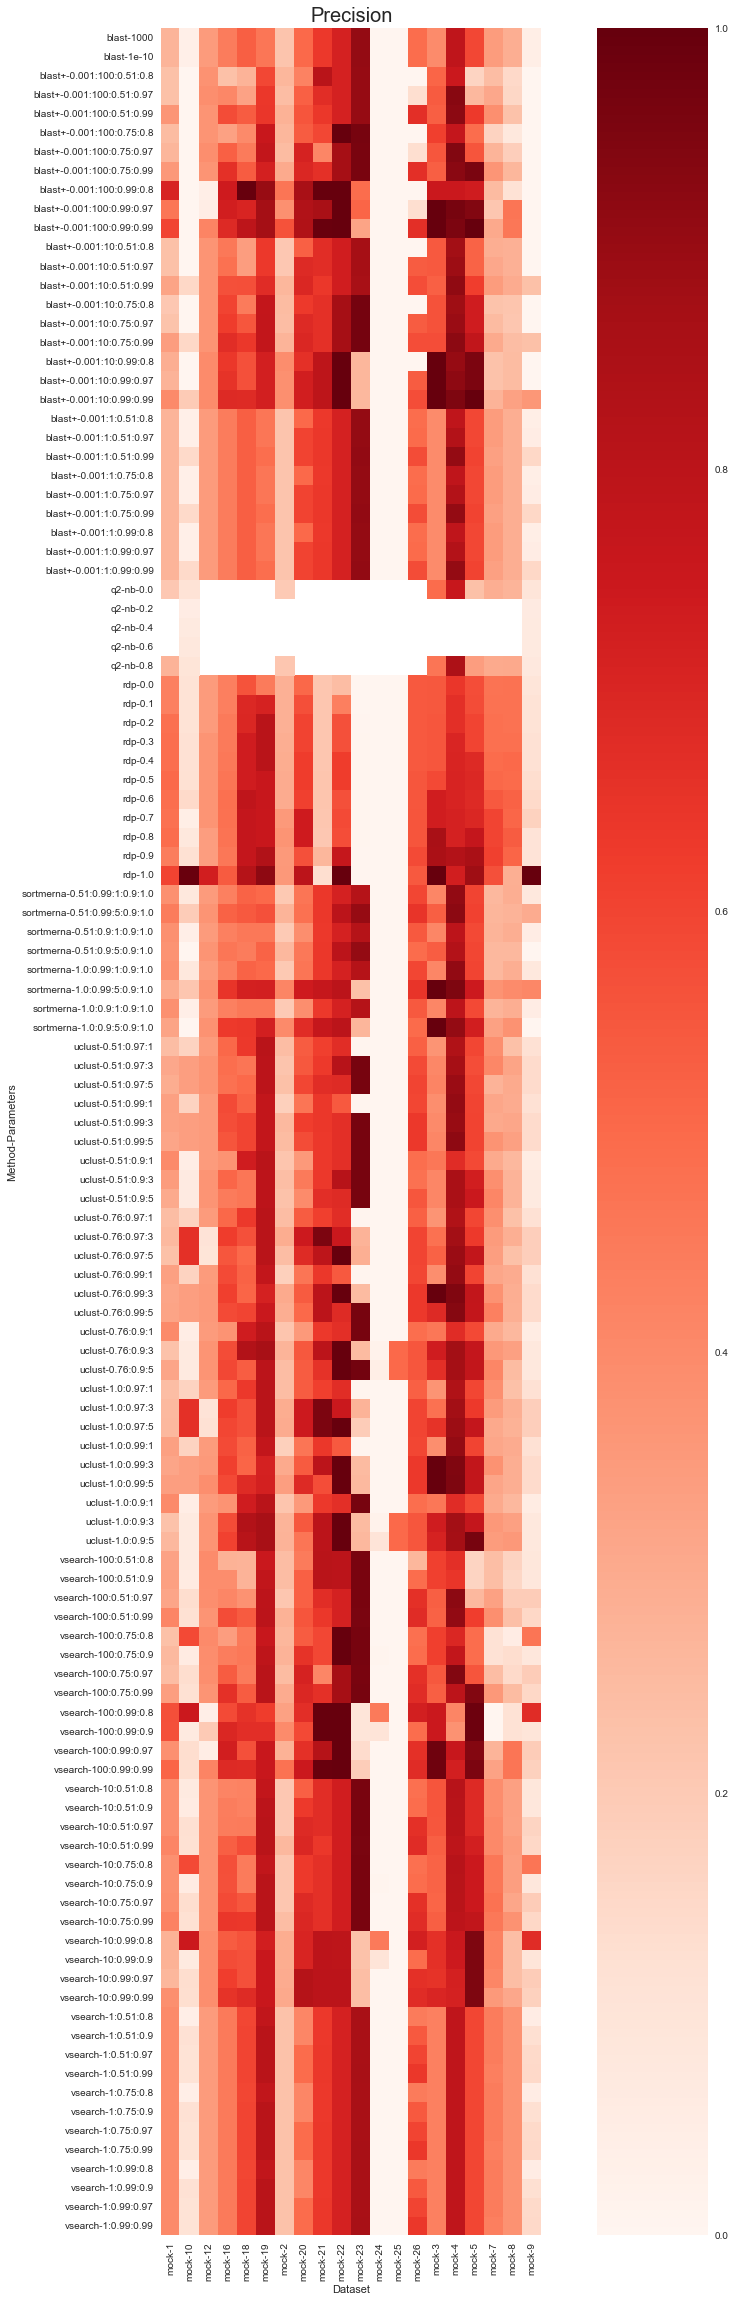

In [19]:
heatmap_from_data_frame(mock_results_6, "Precision")

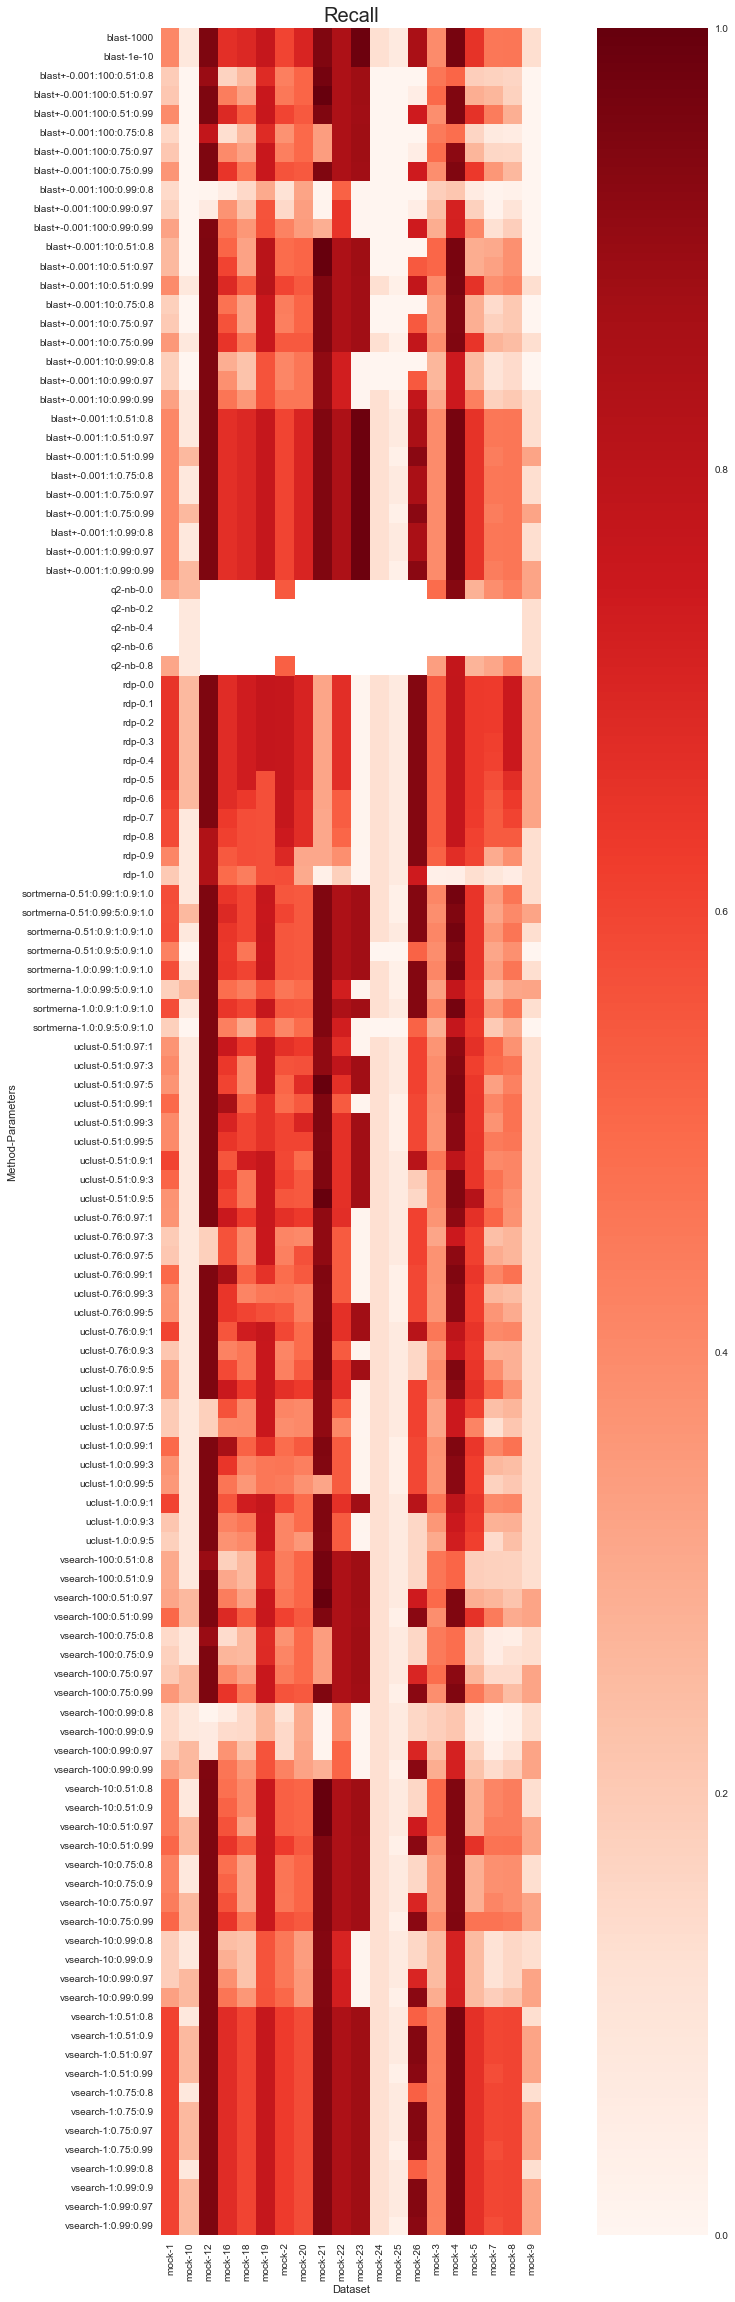

In [20]:
heatmap_from_data_frame(mock_results_6, "Recall")

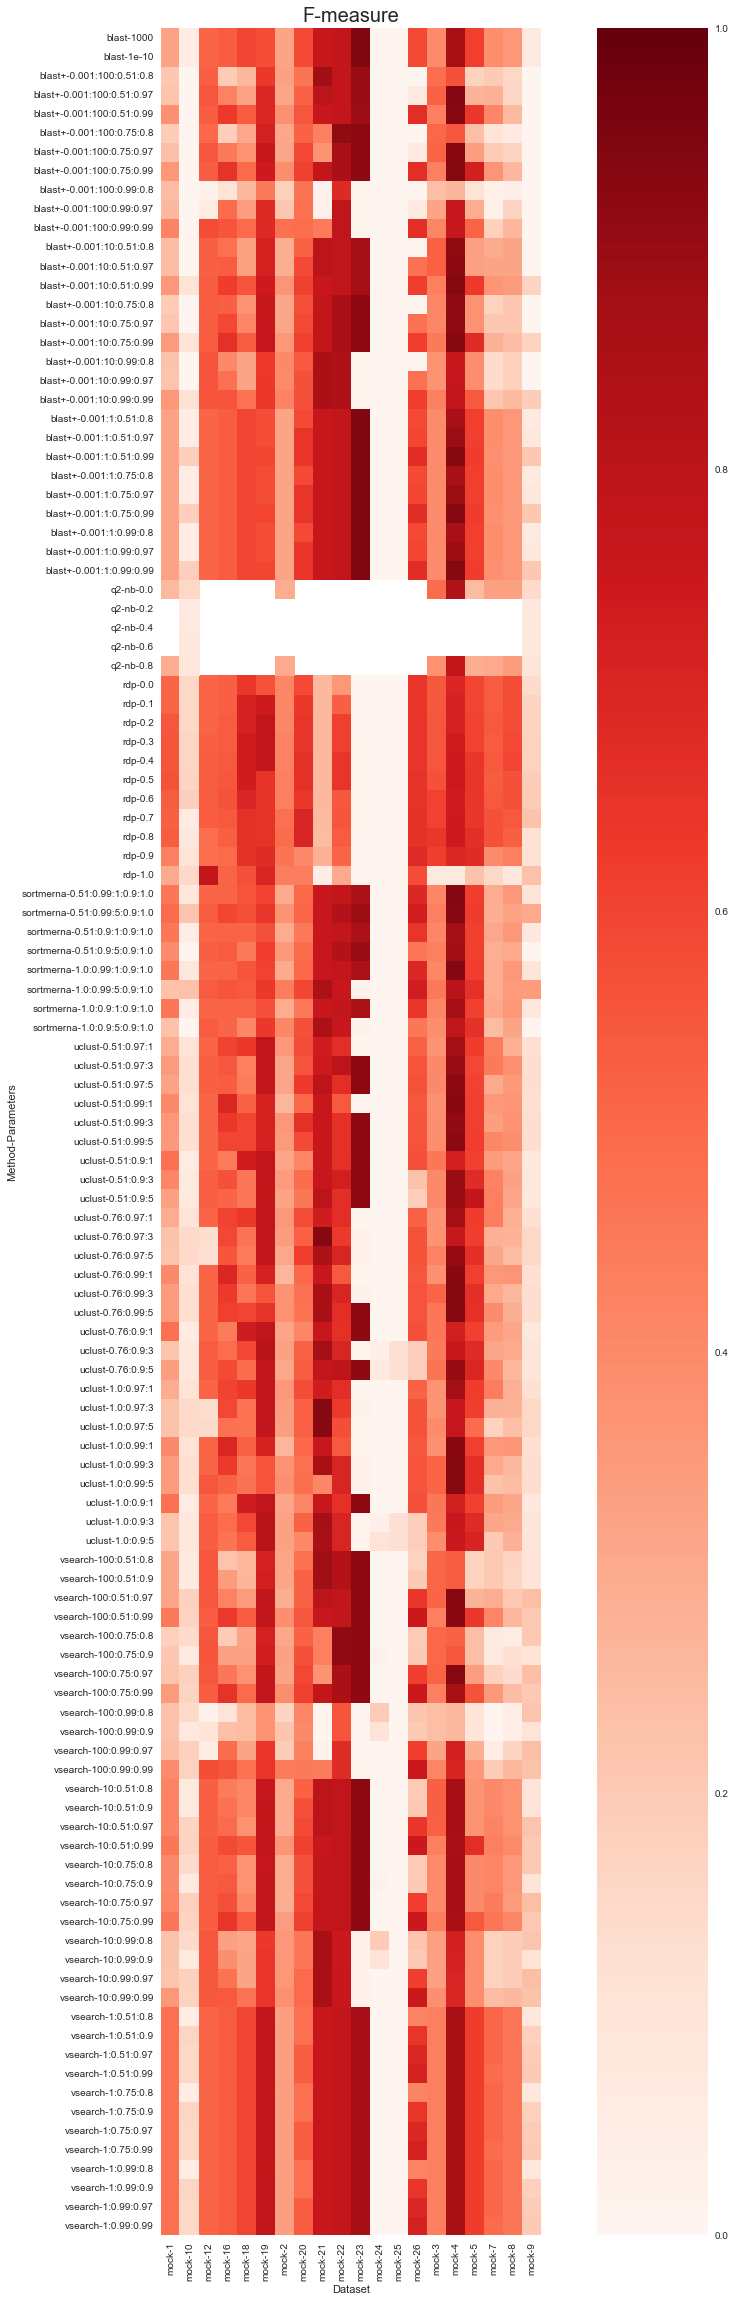

In [21]:
heatmap_from_data_frame(mock_results_6, "F-measure")

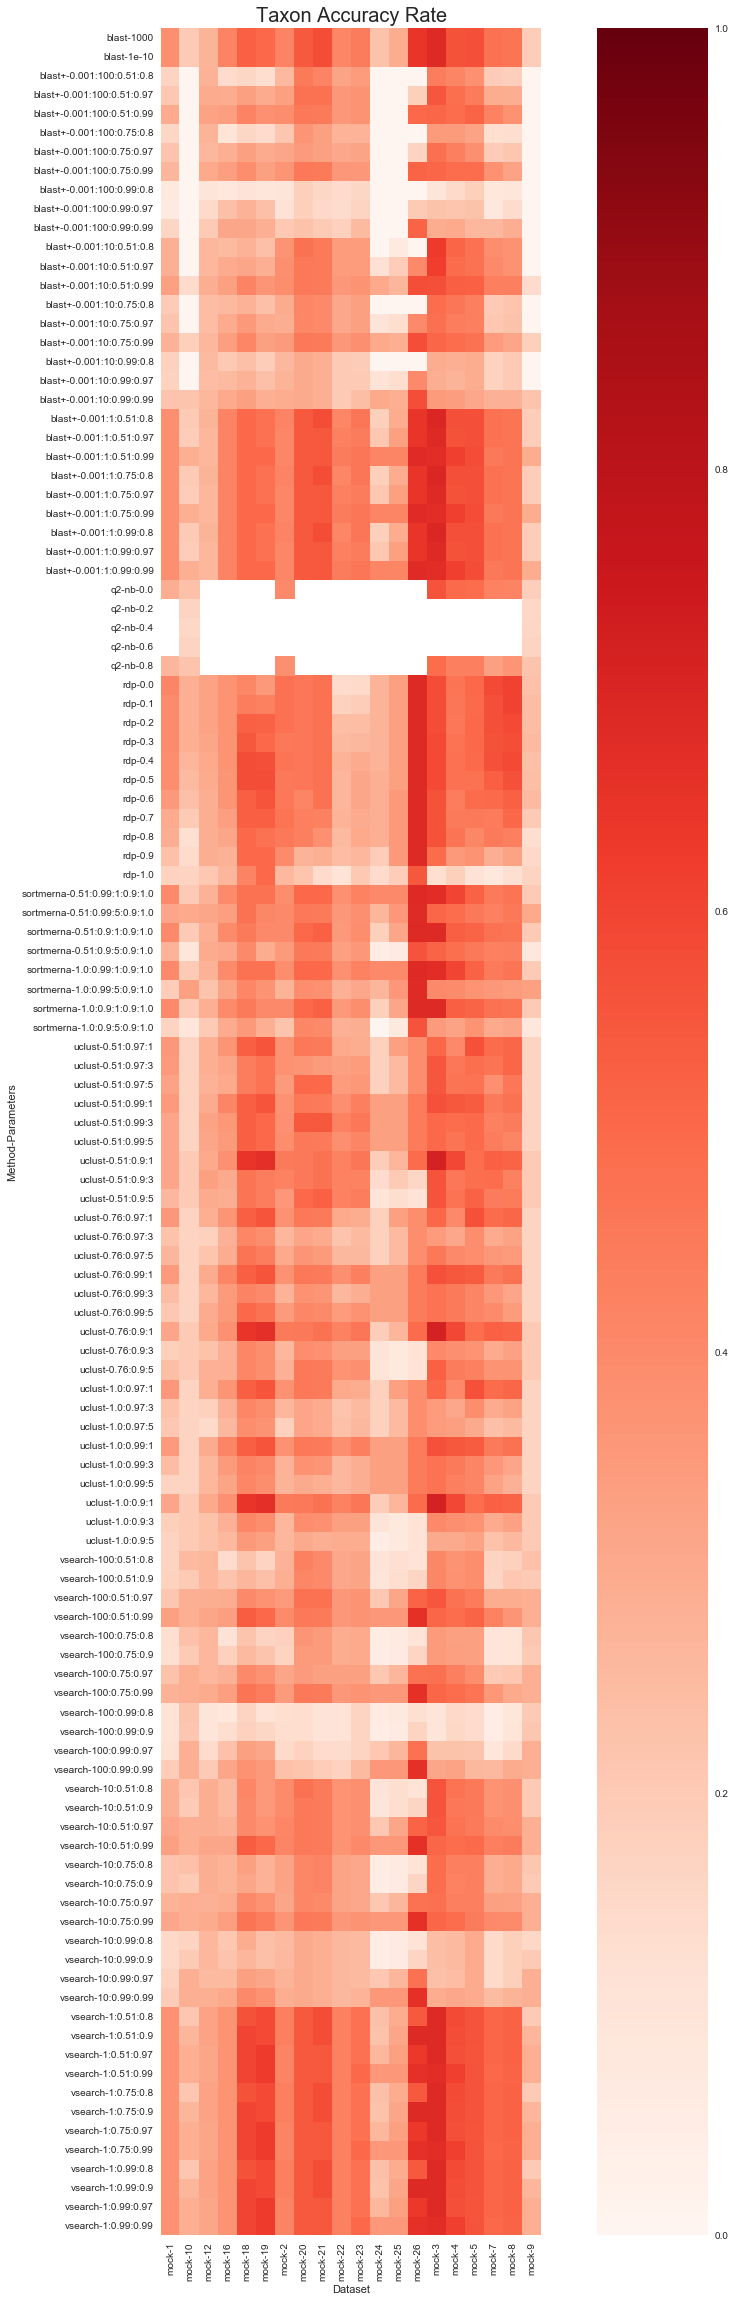

In [22]:
heatmap_from_data_frame(mock_results_6, "Taxon Accuracy Rate")

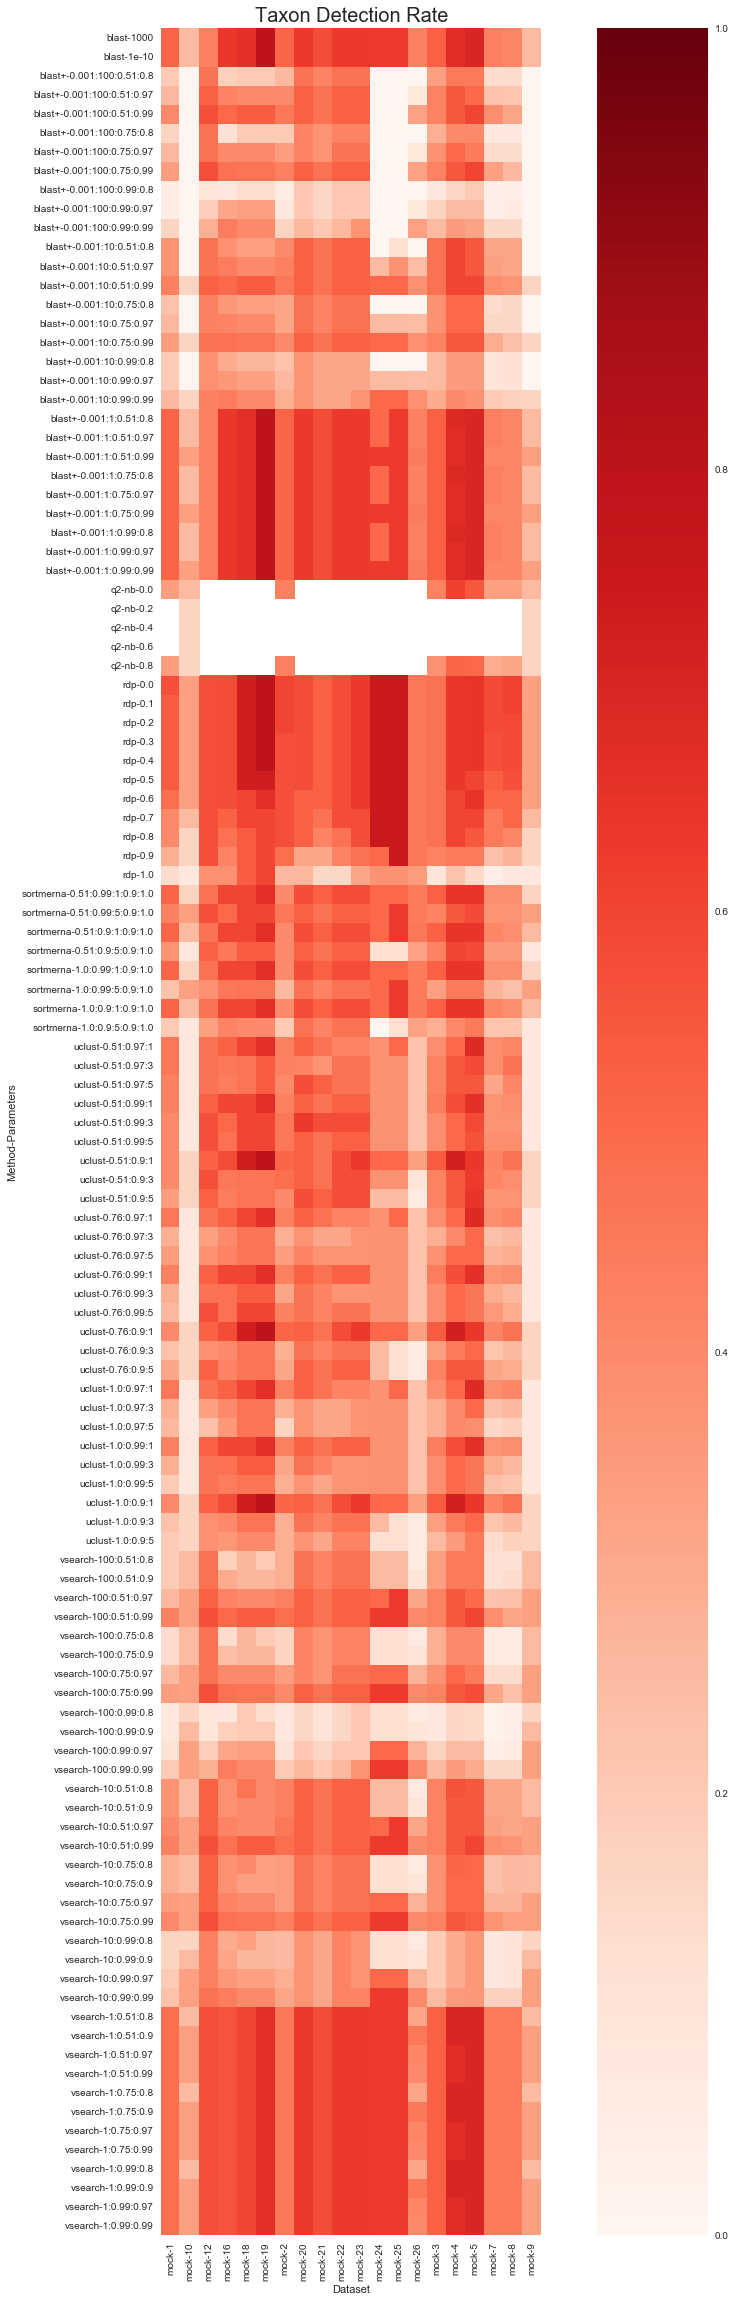

In [23]:
heatmap_from_data_frame(mock_results_6, "Taxon Detection Rate")

### Method Optimization
Which method/parameter configuration performed "best" for a given score? We can rank the top-performing configuration by dataset, method, and taxonomic level.

First, the top-performing method/configuration combination by dataset.

In [24]:
for i in [n for n in range(1,24)]:
    display(Markdown('## mock-{0}'.format(i)))
    best = method_by_dataset_a1(mock_results_6, 'mock-{0}'.format(i))
    display(best)

## mock-1

Method           Parameters  Precision    Recall  F-measure  \
184        rdp                  0.5   0.500637  0.648823   0.565178   
229  sortmerna  0.51:0.99:5:0.9:1.0   0.443959  0.572012   0.499915   
419    vsearch          1:0.75:0.97   0.401430  0.606067   0.482966   
254     uclust           0.51:0.9:1   0.400051  0.603986   0.481308   
144     blast+  0.001:100:0.99:0.99   0.598717  0.324745   0.421090   
4        blast                 1000   0.271153  0.409379   0.326228   
154      q2-nb                  0.8   0.275996  0.312596   0.293158   

     Taxon Accuracy Rate  Taxon Detection Rate  
184             0.387755              0.542857  
229             0.319149              0.428571  
419             0.377778              0.485714  
254             0.318182              0.400000  
144             0.162162              0.171429  
4               0.382979              0.514286  
154             0.266667              0.342857

## mock-2

Method           Parameters  Precision    Recall  F-measure  \
11394        rdp                  0.8   0.367900  0.745502   0.492670   
11339     blast+  0.001:100:0.99:0.99   0.565159  0.422615   0.483602   
11759    vsearch        100:0.99:0.99   0.476179  0.422615   0.447801   
11444  sortmerna   1.0:0.99:5:0.9:1.0   0.417094  0.461353   0.438109   
11579     uclust           1.0:0.99:5   0.339513  0.446908   0.385878   
11199      blast                 1000   0.220794  0.600973   0.322942   
11349      q2-nb                  0.8   0.214471  0.523751   0.304324   

       Taxon Accuracy Rate  Taxon Detection Rate  
11394             0.454545              0.571429  
11339             0.206897              0.171429  
11759             0.233333              0.200000  
11444             0.272727              0.257143  
11579             0.270270              0.285714  
11199             0.418605              0.514286  
11349             0.384615              0.428571

## mock-3

Method          Parameters  Precision    Recall  F-measure  \
70829        rdp                 0.8   0.997743  0.920044   0.957320   
71229     uclust          0.76:0.9:1   0.917853  0.917853   0.917853   
71847    vsearch         10:0.51:0.9   0.934408  0.849091   0.889708   
70287     blast+  0.001:10:0.51:0.97   0.906703  0.849399   0.877116   
71029  sortmerna  1.0:0.99:5:0.9:1.0   1.000000  0.759584   0.863368   
70627      q2-nb                 0.0   0.813363  0.817542   0.815447   
70069      blast               1e-10   0.782694  0.782694   0.782694   

       Taxon Accuracy Rate  Taxon Detection Rate  
70829             0.571429                  0.40  
71229             0.769231                  0.50  
71847             0.611111                  0.55  
70287             0.631579                  0.60  
71029             0.428571                  0.30  
70627             0.611111                  0.55  
70069             0.692308                  0.45

## mock-4

Method           Parameters  Precision    Recall  F-measure  \
80469     uclust           1.0:0.99:5   0.999893  0.985770   0.992781   
79449     blast+  0.001:100:0.75:0.99   0.985456  0.985779   0.985617   
79849  sortmerna  0.51:0.99:5:0.9:1.0   0.983951  0.985779   0.984864   
81029    vsearch        100:0.51:0.99   0.983318  0.985779   0.984547   
78969      blast                1e-10   0.937683  0.987258   0.961832   
79729        rdp                  0.8   0.955103  0.942600   0.948810   
79549      q2-nb                  0.8   0.945248  0.947059   0.946153   

       Taxon Accuracy Rate  Taxon Detection Rate  
80469             0.416667                  0.50  
79449             0.478261                  0.55  
79849             0.478261                  0.55  
81029             0.478261                  0.55  
78969             0.560000                  0.70  
79729             0.444444                  0.60  
79549             0.458333                  0.55

## mock-5

Method           Parameters  Precision    Recall  F-measure  \
83908     blast+  0.001:100:0.75:0.99   0.996905  0.985240   0.991038   
84388  sortmerna   1.0:0.99:5:0.9:1.0   0.998903  0.981863   0.990310   
84908     uclust           1.0:0.99:3   0.982236  0.971837   0.977009   
85568    vsearch        100:0.75:0.99   0.956844  0.985235   0.970832   
84168        rdp                  0.7   0.938948  0.982358   0.960163   
83408      blast                 1000   0.930951  0.986059   0.957713   
84007      q2-nb                  0.8   0.685255  0.350151   0.463476   

       Taxon Accuracy Rate  Taxon Detection Rate  
83908             0.461538                  0.60  
84388             0.346154                  0.45  
84908             0.375000                  0.45  
85568             0.444444                  0.60  
84168             0.413793                  0.60  
83408             0.518519                  0.70  
84007             0.476190                  0.50

## mock-6

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-7

Method           Parameters  Precision    Recall  F-measure  \
91779        rdp                  0.7   0.655133  0.615703   0.634806   
92019     uclust          0.51:0.97:3   0.497448  0.615444   0.550191   
92362    vsearch           1:0.51:0.8   0.482378  0.630615   0.546625   
91539     blast+  0.001:100:0.51:0.99   0.447216  0.507685   0.475536   
91224      blast                1e-10   0.396953  0.524561   0.451922   
91642      q2-nb                  0.0   0.335421  0.438498   0.380095   
91942  sortmerna   1.0:0.99:5:0.9:1.0   0.441069  0.289279   0.349400   

       Taxon Accuracy Rate  Taxon Detection Rate  
91779             0.450980              0.450980  
92019             0.476190              0.392157  
92362             0.522727              0.450980  
91539             0.425532              0.392157  
91224             0.478261              0.431373  
91642             0.425000              0.333333  
91942             0.358974              0.274510

## mock-8

Method          Parameters  Precision    Recall  F-measure  \
95077        rdp                 0.4   0.573505  0.745691   0.648361   
95754    vsearch         1:0.51:0.99   0.373619  0.697341   0.486554   
95289  sortmerna  1.0:0.99:5:0.9:1.0   0.417726  0.416783   0.417254   
95364     uclust         0.51:0.97:3   0.328308  0.571351   0.417000   
95004      q2-nb                 0.8   0.330625  0.535587   0.408857   
94552      blast                1000   0.326068  0.450948   0.378473   
94657     blast+   0.001:1:0.75:0.99   0.326068  0.450948   0.378473   

       Taxon Accuracy Rate  Taxon Detection Rate  
95077             0.600000              0.588235  
95754             0.500000              0.450980  
95289             0.333333              0.235294  
95364             0.489796              0.470588  
95004             0.347826              0.313725  
94552             0.477273              0.411765  
94657             0.477273              0.411765

## mock-9

Method          Parameters  Precision    Recall  F-measure  \
101453  sortmerna  1.0:0.99:5:0.9:1.0   0.341004  0.438953   0.383828   
101333        rdp                 1.0   1.000000  0.169558   0.289952   
102383    vsearch       100:0.99:0.97   0.198578  0.438953   0.273450   
100778     blast+   0.001:1:0.75:0.99   0.190186  0.438953   0.265387   
101798     uclust          1.0:0.97:3   0.183786  0.169558   0.176385   
101108      q2-nb                 0.0   0.097315  0.438953   0.159311   
100673      blast                1000   0.047142  0.169558   0.073773   

        Taxon Accuracy Rate  Taxon Detection Rate  
101453             0.333333              0.333333  
101333             0.166667              0.083333  
102383             0.285714              0.333333  
100778             0.285714              0.333333  
101798             0.166667              0.083333  
101108             0.176471              0.250000  
100673             0.187500              0.250000

## mock-10

Method          Parameters  Precision    Recall  F-measure  \
4684  sortmerna  1.0:0.99:5:0.9:1.0   0.216660  0.293562   0.249316   
3964     blast+   0.001:1:0.51:0.99   0.161682  0.293562   0.208520   
4504        rdp                 0.6   0.160259  0.293562   0.207333   
5374    vsearch        10:0.75:0.97   0.146375  0.293562   0.195346   
4339      q2-nb                 0.0   0.122632  0.293562   0.172997   
5029     uclust          1.0:0.97:3   0.640304  0.086631   0.152615   
3919      blast               1e-10   0.036189  0.086631   0.051052   

      Taxon Accuracy Rate  Taxon Detection Rate  
4684             0.333333              0.333333  
3964             0.285714              0.333333  
4504             0.235294              0.333333  
5374             0.285714              0.333333  
4339             0.230769              0.250000  
5029             0.166667              0.083333  
3919             0.200000              0.250000

## mock-11

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-12

Method           Parameters  Precision    Recall  F-measure  \
5829        rdp                  1.0   0.727667  0.836207   0.778171   
5774     blast+  0.001:100:0.99:0.99   0.419645  0.949025   0.581957   
6184    vsearch        100:0.99:0.99   0.419625  0.949025   0.581938   
6004     uclust           1.0:0.99:5   0.389634  0.950261   0.552661   
5859  sortmerna    1.0:0.9:5:0.9:1.0   0.376056  0.950144   0.538844   
5639      blast                1e-10   0.351361  0.950283   0.513032   

      Taxon Accuracy Rate  Taxon Detection Rate  
5829             0.210526              0.380952  
5774             0.200000              0.285714  
6184             0.200000              0.285714  
6004             0.263158              0.476190  
5859             0.200000              0.333333  
5639             0.272727              0.428571

## mock-13

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-14

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-15

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-16

Method           Parameters  Precision    Recall  F-measure  \
9804      uclust          0.51:0.99:1   0.585262  0.865865   0.698434   
9614      blast+   0.001:10:0.75:0.99   0.674346  0.649305   0.661589   
10064    vsearch        100:0.75:0.99   0.662707  0.649305   0.655937   
9749   sortmerna  0.51:0.99:5:0.9:1.0   0.522604  0.690638   0.594984   
9709         rdp                  0.6   0.483312  0.678995   0.564681   
9534       blast                 1000   0.443385  0.666355   0.532471   

       Taxon Accuracy Rate  Taxon Detection Rate  
9804              0.416667                  0.60  
9614              0.338028                  0.48  
10064             0.338028                  0.48  
9749              0.337838                  0.50  
9709              0.367089                  0.58  
9534              0.421053                  0.64

## mock-17

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-18

Method           Parameters  Precision    Recall  F-measure  \
10374     uclust           0.76:0.9:1   0.737241  0.737241   0.737241   
10249        rdp                  0.3   0.736356  0.737683   0.737019   
10139     blast+    0.001:1:0.99:0.99   0.529439  0.693341   0.600405   
10094      blast                1e-10   0.528275  0.693341   0.599656   
10519    vsearch          1:0.99:0.99   0.599513  0.599513   0.599513   
10304  sortmerna  0.51:0.99:5:0.9:1.0   0.546659  0.599513   0.571868   

       Taxon Accuracy Rate  Taxon Detection Rate  
10374             0.647059              0.733333  
10249             0.550000              0.733333  
10139             0.500000              0.666667  
10094             0.526316              0.666667  
10519             0.600000              0.600000  
10304             0.473684              0.600000

## mock-19

Method           Parameters  Precision    Recall  F-measure  \
10934     uclust           0.76:0.9:3   0.864750  0.762404   0.810358   
10804        rdp                  0.3   0.808117  0.769837   0.788513   
11034    vsearch          1:0.51:0.99   0.806290  0.765852   0.785551   
10724     blast+   0.001:10:0.75:0.99   0.779257  0.760327   0.769675   
10859  sortmerna  0.51:0.99:5:0.9:1.0   0.567321  0.764312   0.651246   
10644      blast                 1000   0.464541  0.768226   0.578978   

       Taxon Accuracy Rate  Taxon Detection Rate  
10934             0.388889              0.466667  
10804             0.500000              0.800000  
11034             0.625000              0.666667  
10724             0.333333              0.466667  
10859             0.409091              0.600000  
10644             0.500000              0.800000

## mock-20

Method          Parameters  Precision    Recall  F-measure  \
12499        rdp                 0.8   0.742185  0.672668   0.705719   
12589     uclust         0.51:0.99:3   0.620663  0.706978   0.661015   
12349     blast+   0.001:1:0.75:0.99   0.602795  0.706942   0.650728   
12784    vsearch        10:0.75:0.99   0.698977  0.545509   0.612780   
12549  sortmerna  1.0:0.99:5:0.9:1.0   0.741255  0.495475   0.593943   
12319      blast               1e-10   0.503361  0.706942   0.588030   

       Taxon Accuracy Rate  Taxon Detection Rate  
12499             0.434783              0.526316  
12589             0.545455              0.631579  
12349             0.545455              0.631579  
12784             0.454545              0.526316  
12549             0.391304              0.473684  
12319             0.545455              0.631579

## mock-21

Method          Parameters  Precision    Recall  F-measure  \
13174     uclust         0.76:0.97:3   0.957016  0.914324   0.935183   
13364    vsearch        100:0.51:0.8   0.805034  0.969247   0.879542   
12969     blast+  0.001:100:0.51:0.8   0.804972  0.969247   0.879504   
13104  sortmerna  1.0:0.99:5:0.9:1.0   0.768089  0.946250   0.847912   
12869      blast                1000   0.634651  0.946496   0.759822   
13059        rdp                 0.9   0.264257  0.309030   0.284895   

       Taxon Accuracy Rate  Taxon Detection Rate  
13174             0.300000              0.315789  
13364             0.400000              0.421053  
12969             0.421053              0.421053  
13104             0.380952              0.421053  
12869             0.578947              0.578947  
13059             0.285714              0.315789

## mock-22

Method           Parameters  Precision    Recall  F-measure  \
13939    vsearch         100:0.75:0.8   0.999306  0.846843   0.916779   
13539     blast+   0.001:100:0.75:0.8   0.999306  0.846843   0.916779   
13639  sortmerna  0.51:0.99:5:0.9:1.0   0.803509  0.847376   0.824860   
13684     uclust          0.51:0.97:3   0.813080  0.786117   0.799371   
13424      blast                 1000   0.717904  0.847521   0.777346   
13594        rdp                  0.5   0.624070  0.668988   0.645749   

       Taxon Accuracy Rate  Taxon Detection Rate  
13939             0.296296              0.421053  
13539             0.275862              0.421053  
13639             0.357143              0.526316  
13684             0.333333              0.473684  
13424             0.413793              0.631579  
13594             0.268293              0.578947

## mock-23

Method          Parameters  Precision    Recall  F-measure  \
13999     blast+   0.001:1:0.51:0.99   0.910438  0.984589   0.946063   
13979      blast                1000   0.909923  0.984589   0.945784   
14274     uclust          0.76:0.9:5   0.975011  0.880078   0.925115   
14494    vsearch        100:0.75:0.8   0.966827  0.883446   0.923257   
14184  sortmerna  0.51:0.9:5:0.9:1.0   0.908365  0.882221   0.895102   
14149        rdp                 0.5   0.011434  0.010512   0.010954   

       Taxon Accuracy Rate  Taxon Detection Rate  
13999             0.461538              0.631579  
13979             0.444444              0.631579  
14274             0.384615              0.526316  
14494             0.307692              0.421053  
14184             0.357143              0.526316  
14149             0.315789              0.631579

Now we can determine which parameter configuration performed best for each method. *Count best* values in each column indicate how many samples a given method achieved within one mean absolute deviation of the best result (which is why they may sum to more than the total number of samples).

In [25]:
for method in mock_results_6['Method'].unique():
    top_params = parameter_comparisons(
        mock_results_6, method, 
        metrics=['Precision', 'Recall', 'F-measure',
                 'Taxon Accuracy Rate', 'Taxon Detection Rate'])
    display(Markdown('## {0}'.format(method)))
    display(top_params[:5])

## blast

F-measure  Precision  Recall  Taxon Accuracy Rate  Taxon Detection Rate
1000         134        134     134                  134                   134
1e-10        134        134     134                  134                   134

## blast+

F-measure  Precision  Recall  Taxon Accuracy Rate  \
0.001:1:0.99:0.99        111         78     131                131.0   
0.001:1:0.99:0.97         99         66     122                128.0   
0.001:1:0.99:0.8          96         61     122                128.0   
0.001:1:0.75:0.99        111         78     131                131.0   
0.001:1:0.75:0.97         99         66     122                128.0   

                   Taxon Detection Rate  
0.001:1:0.99:0.99                 131.0  
0.001:1:0.99:0.97                 131.0  
0.001:1:0.99:0.8                  131.0  
0.001:1:0.75:0.99                 131.0  
0.001:1:0.75:0.97                 131.0

## q2-nb

F-measure  Precision  Recall  Taxon Accuracy Rate  Taxon Detection Rate
0.0         13          9    26.0                   23                    26
0.8         13         19     0.0                    6                     2

## rdp

F-measure  Precision  Recall  Taxon Accuracy Rate  Taxon Detection Rate
0.0         70         47     134                  129                   134
0.1         73         47     134                  129                   134
0.2         74         48     134                  130                   134
0.3         75         51     134                  132                   134
0.4         79         55     134                  134                   134

## sortmerna

F-measure  Precision  Recall  Taxon Accuracy Rate  \
0.51:0.9:1:0.9:1.0          60         35     126                  116   
1.0:0.9:1:0.9:1.0           60         35     126                  116   
0.51:0.99:1:0.9:1.0         84         58     125                  119   
1.0:0.99:1:0.9:1.0          84         58     125                  119   
0.51:0.99:5:0.9:1.0        104         90     127                  107   

                     Taxon Detection Rate  
0.51:0.9:1:0.9:1.0                    133  
1.0:0.9:1:0.9:1.0                     133  
0.51:0.99:1:0.9:1.0                   116  
1.0:0.99:1:0.9:1.0                    116  
0.51:0.99:5:0.9:1.0                   109

## uclust

F-measure  Precision  Recall  Taxon Accuracy Rate  \
0.51:0.9:1          79         35     121                  119   
1.0:0.9:1           79         35     121                  119   
0.76:0.9:1          79         35     121                  119   
0.51:0.97:1         78         48      87                   58   
0.51:0.99:1         90         71      85                   90   

             Taxon Detection Rate  
0.51:0.9:1                    132  
1.0:0.9:1                     132  
0.76:0.9:1                    132  
0.51:0.97:1                    44  
0.51:0.99:1                    44

## vsearch

F-measure  Precision  Recall  Taxon Accuracy Rate  \
1:0.75:0.9         100         51     133                133.0   
1:0.51:0.9         100         51     133                133.0   
1:0.99:0.9         100         51     133                133.0   
1:0.51:0.97        109         57     133                129.0   
1:0.99:0.97        109         57     133                129.0   

             Taxon Detection Rate  
1:0.75:0.9                  134.0  
1:0.51:0.9                  134.0  
1:0.99:0.9                  134.0  
1:0.51:0.97                 124.0  
1:0.99:0.97                 124.0

## Optimized method performance
And, finally, which method performed best at each individual taxonomic level for each reference dataset (i.e., for across all fungal and bacterial mock communities combined)?

For this analysis, we rank the top-performing method/parameter combination for each method at family through species levels. Methods are ranked by top F-measure, and the average value for each metric is shown (rather than count best as above). F-measure distributions are plotted for each method, and compared using paired t-tests with FDR-corrected P-values. This cell does not need to be altered, unless if you wish to change the *metric* used for sorting best methods and for plotting.

## gg_13_8_otus level 4

Method           Parameters  Taxon Accuracy Rate  Taxon Detection Rate  \
6    vsearch        100:0.51:0.99             0.757522              0.905563   
1     blast+   0.001:10:0.75:0.99             0.738802              0.899261   
2      q2-nb                  0.8             0.764733              0.876370   
5     uclust          0.51:0.97:5             0.759659              0.905563   
3        rdp                  0.8             0.723319              0.877085   
4  sortmerna  0.51:0.99:1:0.9:1.0             0.757977              0.905563   
0      blast                 1000             0.760281              0.905563   

   Precision    Recall  F-measure  
6   0.809059  0.994945   0.877858  
1   0.806800  0.994894   0.877482  
2   0.803086  0.986126   0.871353  
5   0.804695  0.986694   0.871288  
3   0.805213  0.981551   0.869472  
4   0.788371  0.991481   0.864457  
0   0.760283  0.997332   0.850140

Method A   Method B         P
0       blast     blast+  0.127475
1       blast      q2-nb  1.000000
2       blast        rdp  0.817294
3       blast  sortmerna  0.641462
4       blast     uclust  0.787652
5       blast    vsearch  0.376028
6      blast+      q2-nb  1.000000
7      blast+        rdp  0.822388
8      blast+  sortmerna  0.376028
9      blast+     uclust  0.974934
10     blast+    vsearch  1.000000
11      q2-nb        rdp  1.000000
12      q2-nb  sortmerna  1.000000
13      q2-nb     uclust  1.000000
14      q2-nb    vsearch  1.000000
15        rdp  sortmerna  0.999101
16        rdp     uclust  0.995072
17        rdp    vsearch  0.288997
18  sortmerna     uclust  0.997293
19  sortmerna    vsearch  0.822388
20     uclust    vsearch  0.885805

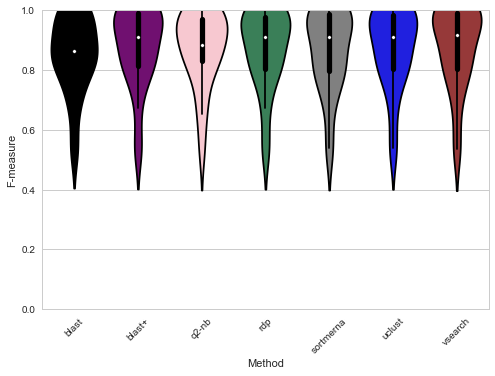

## gg_13_8_otus level 5

Method           Parameters  Taxon Accuracy Rate  Taxon Detection Rate  \
3        rdp                  0.6             0.669921              0.809747   
1     blast+   0.001:10:0.75:0.99             0.613257              0.720290   
6    vsearch        100:0.51:0.99             0.601935              0.707664   
5     uclust          0.76:0.99:5             0.578845              0.670531   
2      q2-nb                  0.8             0.609762              0.676222   
4  sortmerna  0.51:0.99:1:0.9:1.0             0.608102              0.725194   
0      blast                 1000             0.627393              0.752620   

   Precision    Recall  F-measure  
3   0.777495  0.905846   0.825047  
1   0.751387  0.837297   0.782179  
6   0.728206  0.846566   0.773062  
5   0.749265  0.818207   0.772289  
2   0.722111  0.828167   0.763691  
4   0.681108  0.846820   0.743790  
0   0.667921  0.857883   0.740590

Method A   Method B         P
0       blast     blast+  0.010777
1       blast      q2-nb  1.000000
2       blast        rdp  0.001043
3       blast  sortmerna  1.000000
4       blast     uclust  0.059386
5       blast    vsearch  0.088136
6      blast+      q2-nb  1.000000
7      blast+        rdp  0.390798
8      blast+  sortmerna  0.871202
9      blast+     uclust  0.977798
10     blast+    vsearch  0.596261
11      q2-nb        rdp  1.000000
12      q2-nb  sortmerna  1.000000
13      q2-nb     uclust  1.000000
14      q2-nb    vsearch  1.000000
15        rdp  sortmerna  0.085714
16        rdp     uclust  0.024917
17        rdp    vsearch  0.105060
18  sortmerna     uclust  0.966232
19  sortmerna    vsearch  0.966232
20     uclust    vsearch  1.000000

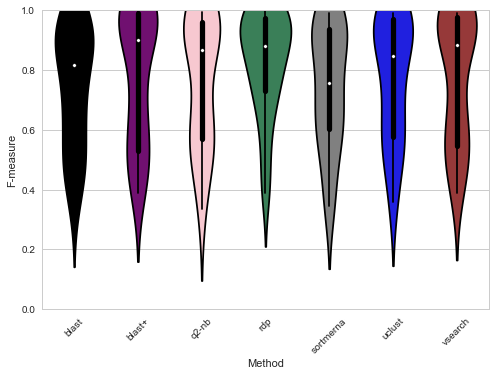

## gg_13_8_otus level 6

Method           Parameters  Taxon Accuracy Rate  Taxon Detection Rate  \
6    vsearch          1:0.75:0.97             0.538427              0.575733   
1     blast+  0.001:100:0.75:0.99             0.417356              0.459769   
5     uclust           0.51:0.9:5             0.459671              0.487088   
3        rdp                  0.8             0.433050              0.508729   
4  sortmerna  0.51:0.99:5:0.9:1.0             0.441576              0.489110   
0      blast                 1000             0.522422              0.577389   
2      q2-nb                  0.0             0.470809              0.456071   

   Precision    Recall  F-measure  
6   0.545449  0.689129   0.599400  
1   0.632669  0.596585   0.592878  
5   0.553119  0.640594   0.584344  
3   0.626898  0.584676   0.583309  
4   0.550298  0.625452   0.572196  
0   0.502048  0.657571   0.561059  
2   0.402621  0.508971   0.443730

Method A   Method B         P
0       blast     blast+  0.624463
1       blast      q2-nb  1.000000
2       blast        rdp  0.999999
3       blast  sortmerna  0.999827
4       blast     uclust  0.997748
5       blast    vsearch  0.098814
6      blast+      q2-nb  1.000000
7      blast+        rdp  1.000000
8      blast+  sortmerna  0.940411
9      blast+     uclust  0.999999
10     blast+    vsearch  1.000000
11      q2-nb        rdp  1.000000
12      q2-nb  sortmerna  1.000000
13      q2-nb     uclust  1.000000
14      q2-nb    vsearch  1.000000
15        rdp  sortmerna  1.000000
16        rdp     uclust  1.000000
17        rdp    vsearch  1.000000
18  sortmerna     uclust  0.999999
19  sortmerna    vsearch  0.940411
20     uclust    vsearch  0.999988

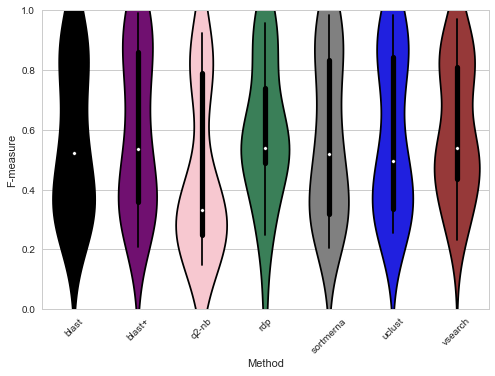

## unite_20.11.2016_clean_fullITS level 4

Method           Parameters  Taxon Accuracy Rate  Taxon Detection Rate  \
6    vsearch         10:0.99:0.99             0.832841              0.498162   
4  sortmerna  0.51:0.99:1:0.9:1.0             0.872001              0.536633   
1     blast+    0.001:1:0.99:0.99             0.863462              0.534183   
3        rdp                  1.0             0.847151              0.528914   
5     uclust            1.0:0.9:1             0.827248              0.529405   
0      blast                 1000             0.877336              0.569346   
2      q2-nb                  0.0             0.673077              1.000000   

   Precision    Recall  F-measure  
6   0.626310  0.915205   0.706503  
4   0.570488  0.892229   0.660916  
1   0.562234  0.902586   0.654177  
3   0.572056  0.875807   0.642382  
5   0.543525  0.900079   0.639951  
0   0.518953  0.910361   0.622397  
2   0.264531  0.717199   0.382224

Method A   Method B         P
0       blast     blast+  0.007231
1       blast      q2-nb  1.000000
2       blast        rdp  0.695158
3       blast  sortmerna  0.005634
4       blast     uclust  0.373997
5       blast    vsearch  0.000010
6      blast+      q2-nb  1.000000
7      blast+        rdp  0.994108
8      blast+  sortmerna  0.998724
9      blast+     uclust  0.941090
10     blast+    vsearch  0.004456
11      q2-nb        rdp  1.000000
12      q2-nb  sortmerna  1.000000
13      q2-nb     uclust  1.000000
14      q2-nb    vsearch  1.000000
15        rdp  sortmerna  0.088819
16        rdp     uclust  0.999999
17        rdp    vsearch  0.000265
18  sortmerna     uclust  0.735099
19  sortmerna    vsearch  0.007738
20     uclust    vsearch  0.000059

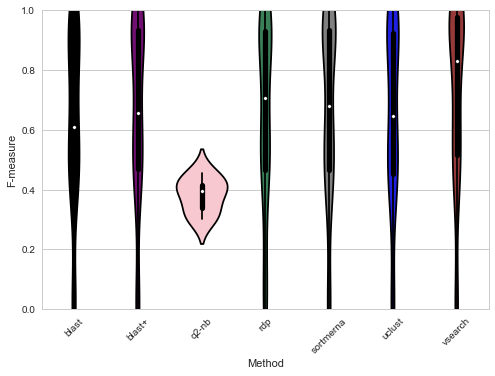

## unite_20.11.2016_clean_fullITS level 5

Method           Parameters  Taxon Accuracy Rate  Taxon Detection Rate  \
6    vsearch        100:0.99:0.99             0.819110              0.485921   
4  sortmerna  0.51:0.99:1:0.9:1.0             0.859666              0.528659   
1     blast+    0.001:1:0.99:0.99             0.851639              0.537402   
3        rdp                  1.0             0.836905              0.519368   
5     uclust            1.0:0.9:1             0.810428              0.513007   
0      blast                 1000             0.855505              0.557104   
2      q2-nb                  0.0             0.482251              0.666667   

   Precision    Recall  F-measure  
6   0.624021  0.908351   0.702998  
4   0.570488  0.892229   0.660916  
1   0.562234  0.902586   0.654177  
3   0.608735  0.875807   0.651464  
5   0.539798  0.892547   0.635036  
0   0.516097  0.902829   0.618294  
2   0.170069  0.463047   0.246457

Method A   Method B         P
0       blast     blast+  0.003328
1       blast      q2-nb  1.000000
2       blast        rdp  0.047249
3       blast  sortmerna  0.000941
4       blast     uclust  0.459664
5       blast    vsearch  0.000010
6      blast+      q2-nb  1.000000
7      blast+        rdp  0.999998
8      blast+  sortmerna  0.998724
9      blast+     uclust  0.782695
10     blast+    vsearch  0.016480
11      q2-nb        rdp  1.000000
12      q2-nb  sortmerna  1.000000
13      q2-nb     uclust  1.000000
14      q2-nb    vsearch  1.000000
15        rdp  sortmerna  0.748361
16        rdp     uclust  0.904772
17        rdp    vsearch  0.002987
18  sortmerna     uclust  0.466167
19  sortmerna    vsearch  0.020180
20     uclust    vsearch  0.000052

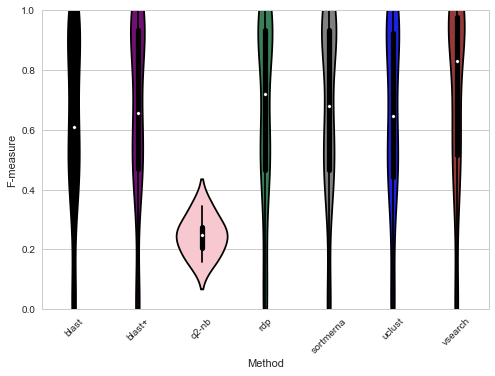

## unite_20.11.2016_clean_fullITS level 6

Method          Parameters  Taxon Accuracy Rate  Taxon Detection Rate  \
6    vsearch        10:0.99:0.99             0.634947              0.402015   
4  sortmerna  1.0:0.99:5:0.9:1.0             0.656102              0.442860   
3        rdp                 0.9             0.647680              0.444039   
1     blast+   0.001:1:0.99:0.99             0.654569              0.441467   
0      blast                1000             0.611874              0.419597   
5     uclust          0.76:0.9:1             0.472961              0.331904   
2      q2-nb                 0.0             0.207296              0.250000   

   Precision    Recall  F-measure  
6   0.634510  0.873905   0.707028  
4   0.618356  0.885771   0.692788  
3   0.546586  0.875060   0.636045  
1   0.546366  0.873905   0.633799  
0   0.454307  0.800586   0.545847  
5   0.451409  0.756085   0.533303  
2   0.103370  0.288393   0.150212

Method A   Method B             P
0       blast     blast+  8.756711e-05
1       blast      q2-nb  1.000000e+00
2       blast        rdp  6.812228e-05
3       blast  sortmerna  3.628813e-09
4       blast     uclust  9.781246e-01
5       blast    vsearch  4.055582e-08
6      blast+      q2-nb  1.000000e+00
7      blast+        rdp  9.999955e-01
8      blast+  sortmerna  1.034089e-04
9      blast+     uclust  1.604984e-04
10     blast+    vsearch  2.601652e-04
11      q2-nb        rdp  1.000000e+00
12      q2-nb  sortmerna  1.000000e+00
13      q2-nb     uclust  1.000000e+00
14      q2-nb    vsearch  1.000000e+00
15        rdp  sortmerna  1.631188e-08
16        rdp     uclust  1.363297e-04
17        rdp    vsearch  1.735607e-04
18  sortmerna     uclust  1.799385e-08
19  sortmerna    vsearch  9.829055e-01
20     uclust    vsearch  1.802178e-09

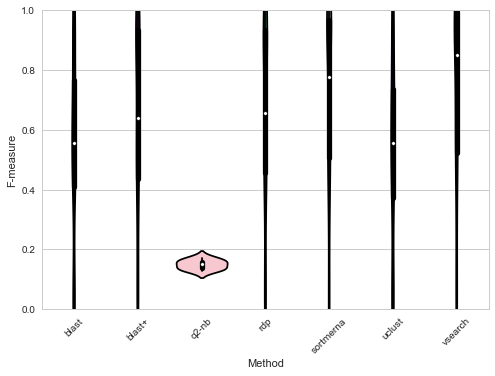

In [26]:
rank_optimized_method_performance_by_dataset(mock_results,
                                             dataset="Reference",
                                             metric="F-measure",
                                             level_range=range(4,7),
                                             display_fields=["Method",
                                                             "Parameters",
                                                             "Taxon Accuracy Rate",
                                                             "Taxon Detection Rate",
                                                             "Precision",
                                                             "Recall",
                                                             "F-measure"],
                                             paired=True,
                                             parametric=True,
                                             color=None,
                                             color_pallette=color_pallette)

## gg_13_8_otus level 6

Method           Parameters  Taxon Accuracy Rate  Taxon Detection Rate  \
6    vsearch          1:0.99:0.99             0.542722              0.575733   
5     uclust           0.76:0.9:1             0.532029              0.572451   
1     blast+    0.001:1:0.99:0.99             0.525470              0.575289   
0      blast                 1000             0.522422              0.577389   
4  sortmerna  0.51:0.99:1:0.9:1.0             0.505285              0.541901   
3        rdp                  0.4             0.497297              0.594122   
2      q2-nb                  0.0             0.470809              0.456071   

   Precision    Recall  F-measure  
6   0.544390  0.686703   0.597835  
5   0.502874  0.616119   0.543603  
1   0.524096  0.655146   0.572972  
0   0.502048  0.657571   0.561059  
4   0.513621  0.637801   0.559756  
3   0.549934  0.649047   0.583304  
2   0.402621  0.508971   0.443730

Method A   Method B         P
0       blast     blast+  0.999000
1       blast      q2-nb  1.000000
2       blast        rdp  0.884502
3       blast  sortmerna  0.178951
4       blast     uclust  0.998062
5       blast    vsearch  0.186639
6      blast+      q2-nb  1.000000
7      blast+        rdp  0.884502
8      blast+  sortmerna  0.004618
9      blast+     uclust  0.999700
10     blast+    vsearch  0.351297
11      q2-nb        rdp  1.000000
12      q2-nb  sortmerna  1.000000
13      q2-nb     uclust  1.000000
14      q2-nb    vsearch  1.000000
15        rdp  sortmerna  0.999700
16        rdp     uclust  0.390044
17        rdp    vsearch  0.110384
18  sortmerna     uclust  0.390044
19  sortmerna    vsearch  0.000438
20     uclust    vsearch  0.950157

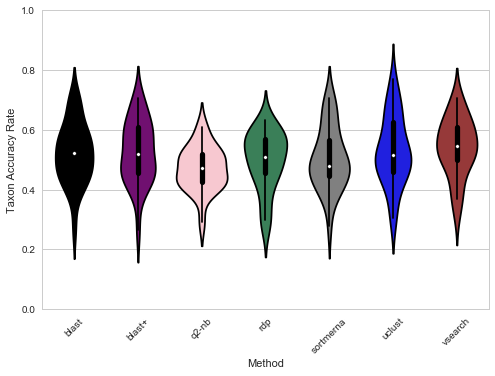

## unite_20.11.2016_clean_fullITS level 6

Method          Parameters  Taxon Accuracy Rate  Taxon Detection Rate  \
4  sortmerna  1.0:0.99:5:0.9:1.0             0.656102              0.442860   
3        rdp                 0.3             0.656101              0.456690   
1     blast+   0.001:1:0.99:0.99             0.654569              0.441467   
6    vsearch          1:0.75:0.9             0.654532              0.453473   
0      blast                1000             0.611874              0.419597   
5     uclust           1.0:0.9:1             0.472961              0.331904   
2      q2-nb                 0.8             0.222222              0.166667   

   Precision    Recall  F-measure  
4   0.618356  0.885771   0.692788  
3   0.509617  0.886089   0.608987  
1   0.546366  0.873905   0.633799  
6   0.510355  0.886089   0.609529  
0   0.454307  0.800586   0.545847  
5   0.451409  0.756085   0.533303  
2   0.088675  0.106742   0.092683

Method A   Method B             P
0       blast     blast+  1.074044e-05
1       blast      q2-nb  1.000000e+00
2       blast        rdp  3.333867e-11
3       blast  sortmerna  5.489092e-07
4       blast     uclust  0.000000e+00
5       blast    vsearch  1.331385e-10
6      blast+      q2-nb  1.000000e+00
7      blast+        rdp  9.999988e-01
8      blast+  sortmerna  9.999930e-01
9      blast+     uclust  0.000000e+00
10     blast+    vsearch  1.000000e+00
11      q2-nb        rdp  1.000000e+00
12      q2-nb  sortmerna  1.000000e+00
13      q2-nb     uclust  1.000000e+00
14      q2-nb    vsearch  1.000000e+00
15        rdp  sortmerna  1.000000e+00
16        rdp     uclust  0.000000e+00
17        rdp    vsearch  8.522648e-01
18  sortmerna     uclust  0.000000e+00
19  sortmerna    vsearch  9.999984e-01
20     uclust    vsearch  0.000000e+00

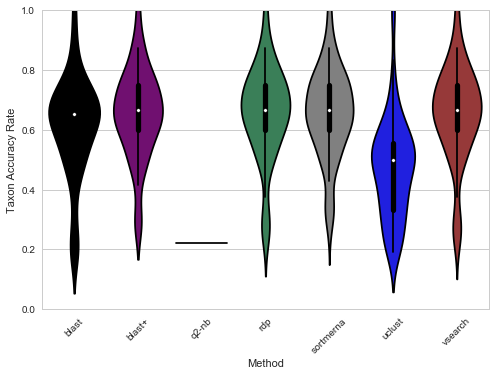

In [27]:
rank_optimized_method_performance_by_dataset(mock_results,
                                             dataset="Reference",
                                             metric="Taxon Accuracy Rate",
                                             level_range=range(6,7),
                                             display_fields=["Method",
                                                             "Parameters",
                                                             "Taxon Accuracy Rate",
                                                             "Taxon Detection Rate",
                                                             "Precision",
                                                             "Recall",
                                                             "F-measure"],
                                             paired=True,
                                             parametric=True,
                                             color=None,
                                             color_pallette=color_pallette)

## Beta diversity method/parameter comparisons
Principal coordinate analysis offers a neat way to assess the relative performance of multiple methods to reconstruct expected compositions. Methods that cluster with the "expected" composition probably outperform those that appear more distant on a PCoA plot. First, we need to merge biom tables from each method/parameter configuration for each dataset/reference/level combination, so that we can compare each method/parameter as a separate "sample".

__*Note: if you have added additional methods and are attempting to recompute results, set force=True.*__


In [28]:
merge_expected_and_observed_tables(expected_results_dir, results_dirs, taxonomy_level=6, force=False)

SystemExit: Skipping merge. Set force=True if you intend to generate new merged tables.

/Users/benkaehler/miniconda3/envs/qiime2-dev/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Now we can manually select which table we want to view. This will output a Bray-Curtis PCoA plot, in addition to ANOSIM test results, which indicate whether at least two methods are significantly different from each other.

These plots are useful for visualizing the relative performance of different methods and their configurations relative to each other and to expected compositions, but are primarily a qualitative technique and do not really give us an idea of whether method X actually performs better than method Y.

__*Note that 2D plots will only appear if you are running notebooks locally. If viewing static notebooks online, make sure you are viewing this notebook in [nbviewer](http://nbviewer.jupyter.org/). (if viewing on GitHub, just copy the URL and paste into the search bar in nbviewer.)*__

In [29]:
table = join(expected_results_dir, 'mock-18', 'gg_13_8_otus', 'merged_table.biom')
sample_md, results, pc, dm = beta_diversity_pcoa(table, method="braycurtis", dim=2,
                                                 permutations=99, col='method', 
                                                 colormap=color_pallette)

R =  0.107665960452 ; P =  0.01


/Users/benkaehler/miniconda3/envs/qiime2-dev/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.42505872571981496 and the largest is 4.417440878355716.
  RuntimeWarning


Loading BokehJS ...

You can also view all beta diversity plots with a single command, ``batch_beta_diversity()``, but we will only show single dataset examples in these example notebooks.

### Average distance between expected results and observed results for each method 


As we already discussed, PCoA plots are good for a qualitative overview, but don't offer much in the way of quantitative comparison. Instead, we can directly compare the Bray-Curtis dissimilarity between methods, and utilize pairwise Mann-Whitney U tests to determine precisely which methods perform better (lower distance = more accurate classification). In the cell below, we will use distance comparisons to determine:

    1) Whether the dissimilarity between taxonomic assignment with different parameters of the same method is greater or less than the dissimilarity between taxonomic assignments with different methods, including the expected composition.
    2) which method (averaged across all configurations) most closely reproduces the expected composition.
    
You can generate boxplots for individual datasets one-by-one with ``per_method_boxplots()``, or for all datasets individually with ``fastlane_boxplots()``. However, here we are most interested in the average performance of methods across each dataset.

The command below violin plots of distribution of distances between expected composition and predicted compositions for each method (all parameter configurations) across all samples/datasets, and pairwise Mann Whitney U tests between these distributions.

## gg_13_8_otus

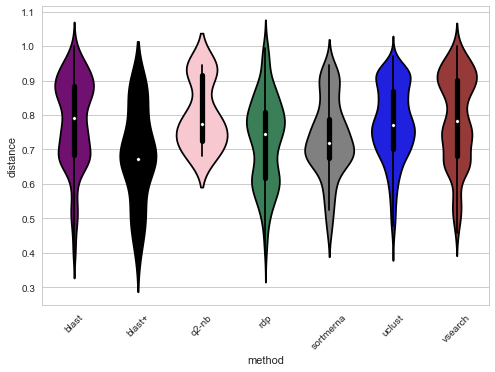

method A   method B             P
0      blast+      blast  4.613902e-06
1      blast+      q2-nb  7.597099e-01
2      blast+        rdp  1.509068e-08
3      blast+  sortmerna  1.270810e-05
4      blast+     uclust  8.736689e-01
5      blast+    vsearch  7.519476e-01
6       blast      q2-nb  1.313426e-04
7       blast        rdp  2.478060e-01
8       blast  sortmerna  7.161906e-02
9       blast     uclust  1.421662e-07
10      blast    vsearch  6.293324e-07
11      q2-nb        rdp  2.729586e-03
12      q2-nb  sortmerna  2.729586e-03
13      q2-nb     uclust  6.607385e-01
14      q2-nb    vsearch  8.736689e-01
15        rdp  sortmerna  8.736689e-01
16        rdp     uclust  1.287590e-09
17        rdp    vsearch  1.779610e-11
18  sortmerna     uclust  2.166953e-06
19  sortmerna    vsearch  1.845250e-07
20     uclust    vsearch  4.496220e-01

## unite_20.11.2016_clean_fullITS

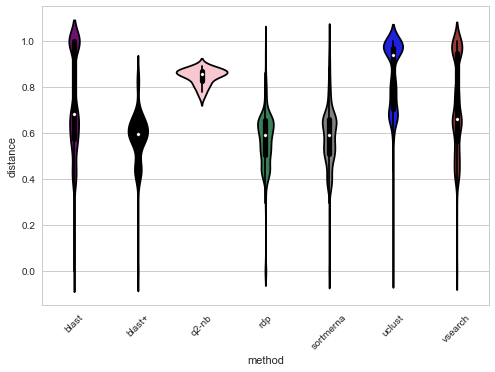

method A   method B         P
0      blast+      blast  0.000000
1      blast+      q2-nb  0.013377
2      blast+        rdp  0.000000
3      blast+  sortmerna  0.000000
4      blast+     uclust  0.000000
5      blast+    vsearch  0.642323
6       blast      q2-nb  0.000000
7       blast        rdp  0.658687
8       blast  sortmerna  0.737130
9       blast     uclust  0.000000
10      blast    vsearch  0.000000
11      q2-nb        rdp  0.000000
12      q2-nb  sortmerna  0.000000
13      q2-nb     uclust  0.794764
14      q2-nb    vsearch  0.005153
15        rdp  sortmerna  0.021680
16        rdp     uclust  0.000000
17        rdp    vsearch  0.000000
18  sortmerna     uclust  0.000000
19  sortmerna    vsearch  0.000000
20     uclust    vsearch  0.000000

None

In [30]:
results = average_distance_boxplots(expected_results_dir, paired=False,
                                    use_best=False, color_pallette=color_pallette)
display(results)

### Average distance between expected results and observed results for each method with optimized parameters 
Reports the top-performing parameter configuration for each method, violin plots of distribution of distances between expected composition and predicted compositions for the top parameter for each method across all samples/datasets, and pairwise paired Wilcoxon signed rank tests between these distributions.

## gg_13_8_otus

method               params
0     blast+     0.001:1:0.99:0.8
1      blast                 1000
2      q2-nb                  0.0
3        rdp                  0.3
4  sortmerna  0.51:0.99:1:0.9:1.0
5     uclust           0.76:0.9:1
6    vsearch          1:0.99:0.99

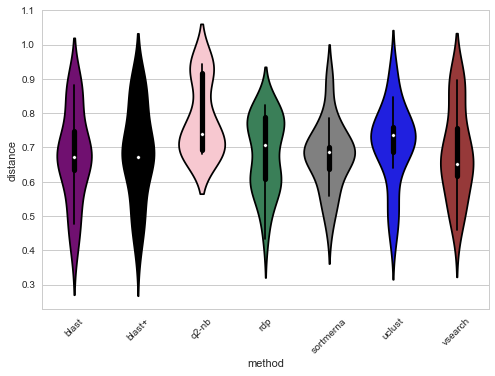

method A   method B         P
0      blast+      blast  0.288080
1      blast+      q2-nb  1.000000
2      blast+        rdp  1.000000
3      blast+  sortmerna  1.000000
4      blast+     uclust  0.431959
5      blast+    vsearch  0.836601
6       blast      q2-nb  1.000000
7       blast        rdp  0.999999
8       blast  sortmerna  0.999999
9       blast     uclust  0.754548
10      blast    vsearch  0.999999
11      q2-nb        rdp  1.000000
12      q2-nb  sortmerna  1.000000
13      q2-nb     uclust  1.000000
14      q2-nb    vsearch  1.000000
15        rdp  sortmerna  1.000000
16        rdp     uclust  0.596355
17        rdp    vsearch  0.999998
18  sortmerna     uclust  0.480903
19  sortmerna    vsearch  0.999998
20     uclust    vsearch  0.762150

## unite_20.11.2016_clean_fullITS

method              params
0     blast+   0.001:1:0.99:0.99
1      blast                1000
2      q2-nb                 0.0
3        rdp                 0.3
4  sortmerna  1.0:0.99:5:0.9:1.0
5     uclust           1.0:0.9:1
6    vsearch         1:0.99:0.99

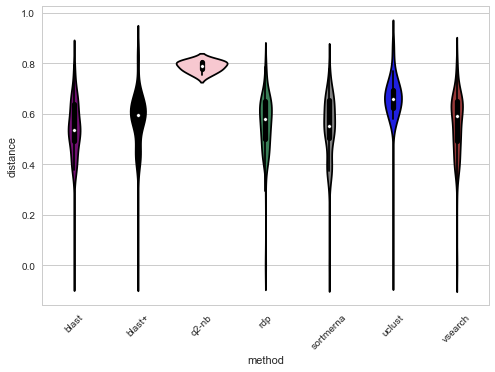

method A   method B             P
0      blast+      blast  0.000000e+00
1      blast+      q2-nb  1.000000e+00
2      blast+        rdp  0.000000e+00
3      blast+  sortmerna  3.057254e-02
4      blast+     uclust  0.000000e+00
5      blast+    vsearch  4.109293e-07
6       blast      q2-nb  1.000000e+00
7       blast        rdp  3.491831e-07
8       blast  sortmerna  4.263256e-14
9       blast     uclust  2.275840e-10
10      blast    vsearch  3.768143e-08
11      q2-nb        rdp  1.000000e+00
12      q2-nb  sortmerna  1.000000e+00
13      q2-nb     uclust  1.000000e+00
14      q2-nb    vsearch  1.000000e+00
15        rdp  sortmerna  1.676176e-05
16        rdp     uclust  1.998401e-15
17        rdp    vsearch  8.844002e-02
18  sortmerna     uclust  3.019807e-14
19  sortmerna    vsearch  5.078448e-03
20     uclust    vsearch  4.996004e-14

In [31]:
results = average_distance_boxplots(expected_results_dir,
                                    color_pallette=color_pallette)
results